# 3D-BPP

## Pre-requisites

In [1]:
import os
from collections import namedtuple
from time import time

import numpy as np
import pandas as pd
import seaborn as sns
from ortools.sat.python import cp_model
from matplotlib import pyplot as plt
from tqdm import tqdm

from src import config, dataset, main, utils, bins

In [2]:
%matplotlib notebook
%load_ext autoreload
%load_ext nb_black
%autoreload 2

<IPython.core.display.Javascript object>

In [3]:
plt.style.use("seaborn")
np.random.seed(config.RANDOM_SEED)

<IPython.core.display.Javascript object>

## Pallets and containers

Pallet EUR:

|       |  $L\times W\times H (cm)$   | Load (kg)  |
|:-----:|:--------------------------:|:--------:|
| EUR 1 |  $80\times 120\times 14.5$ |  $2490$  |
| EUR 2 | $120\times 100\times 14.4$ |  $1470$  |
| EUR 3 | $100\times 120\times 14.4$ |  $1920$  |
| EUR 6 |  $80\times 60\times 14.4$  |   $500$  |

Container ISO:

|   |  $L\times W\times H (cm)$  | Load (kg) |
|:-:|:--------------------------:|:--------:|
| 1A | $233\times 1200\times 220$ |  $26480$ |
| 1C |  $233\times 587\times 220$ |  $28180$ |

## Dataset

### Products

In [4]:
product_dataset = dataset.ProductDataset(
    "data/products.pkl",
    config.NUM_PRODUCTS,
    config.MIN_PRODUCT_WIDTH,
    config.MAX_PRODUCT_WIDTH,
    config.MIN_PRODUCT_DEPTH,
    config.MAX_PRODUCT_DEPTH,
    config.MIN_PRODUCT_HEIGHT,
    config.MAX_PRODUCT_HEIGHT,
    config.MIN_PRODUCT_WEIGHT,
    config.MAX_PRODUCT_WEIGHT,
    force_overload=False,
)
product_dataset.products.head()

,width,depth,height,weight,volume
0,160,280,233,8,10438400
1,199,269,260,11,13918060
2,187,101,283,2,5345021
3,126,149,214,2,4017636
4,248,132,280,3,9166080


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


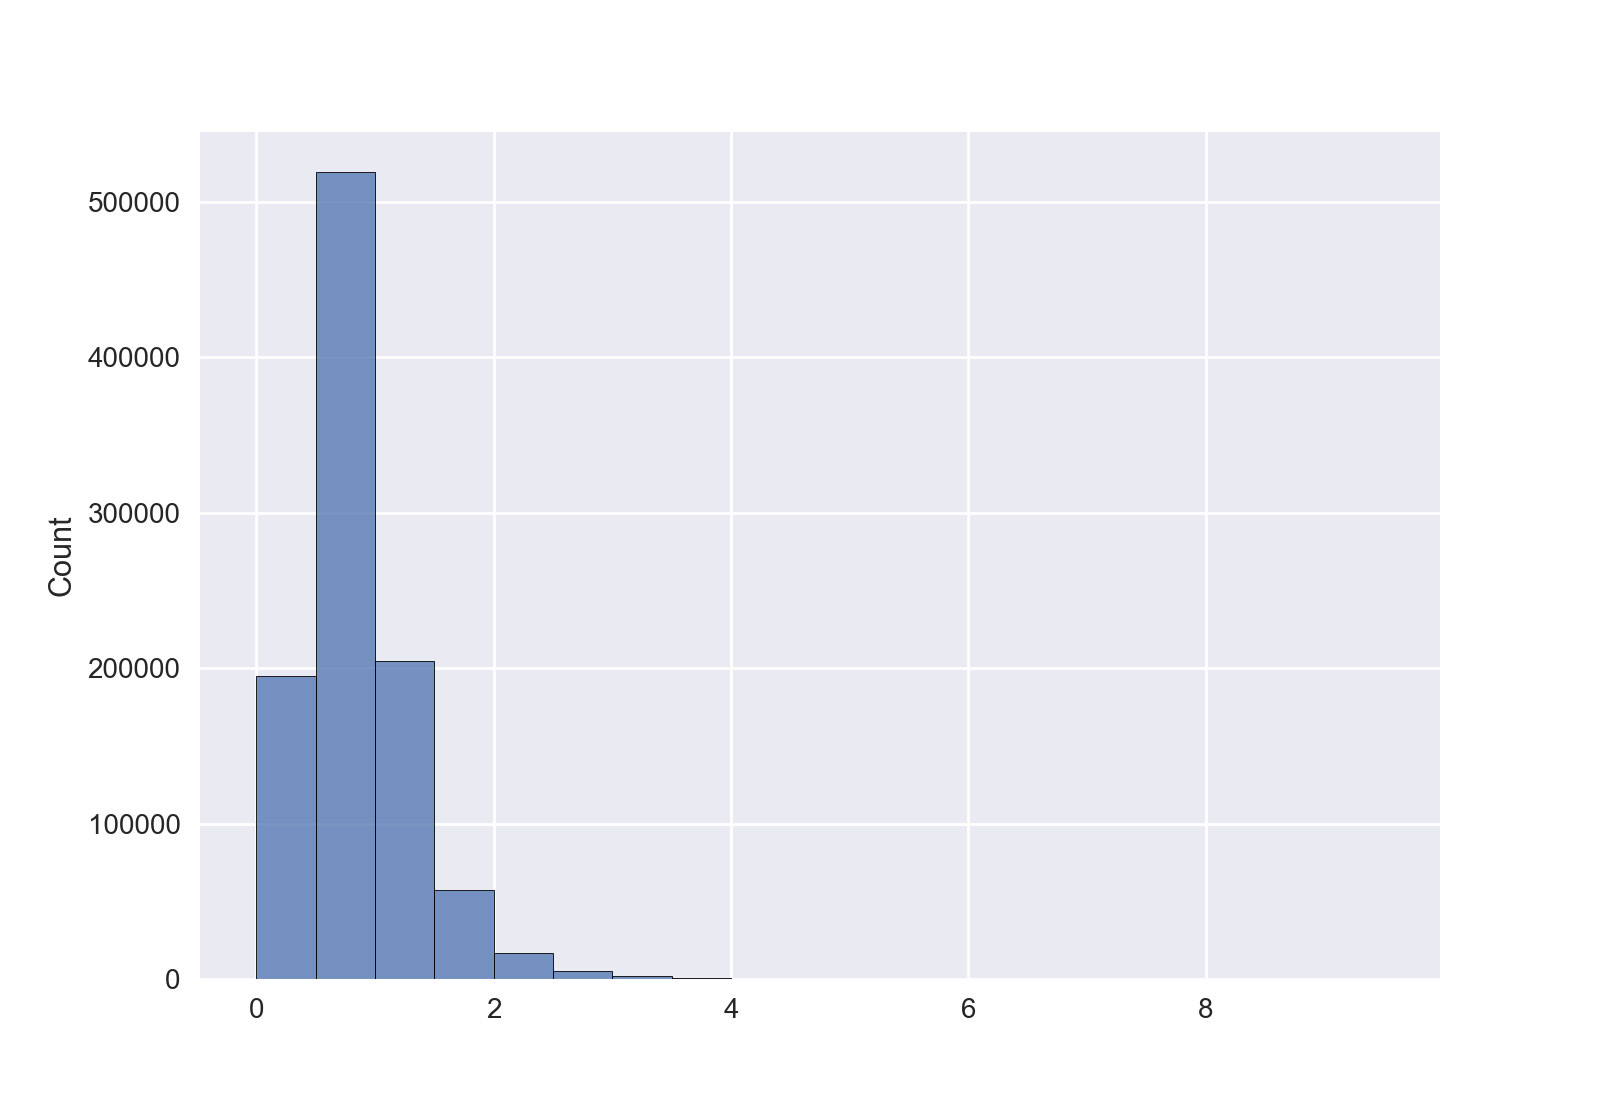

<IPython.core.display.Javascript object>

In [59]:
plt.figure()
sns.histplot(
    product_dataset.products.depth / product_dataset.products.width,
    bins=np.arange(0, 10, 0.5),
)
plt.show()

<IPython.core.display.Javascript object>


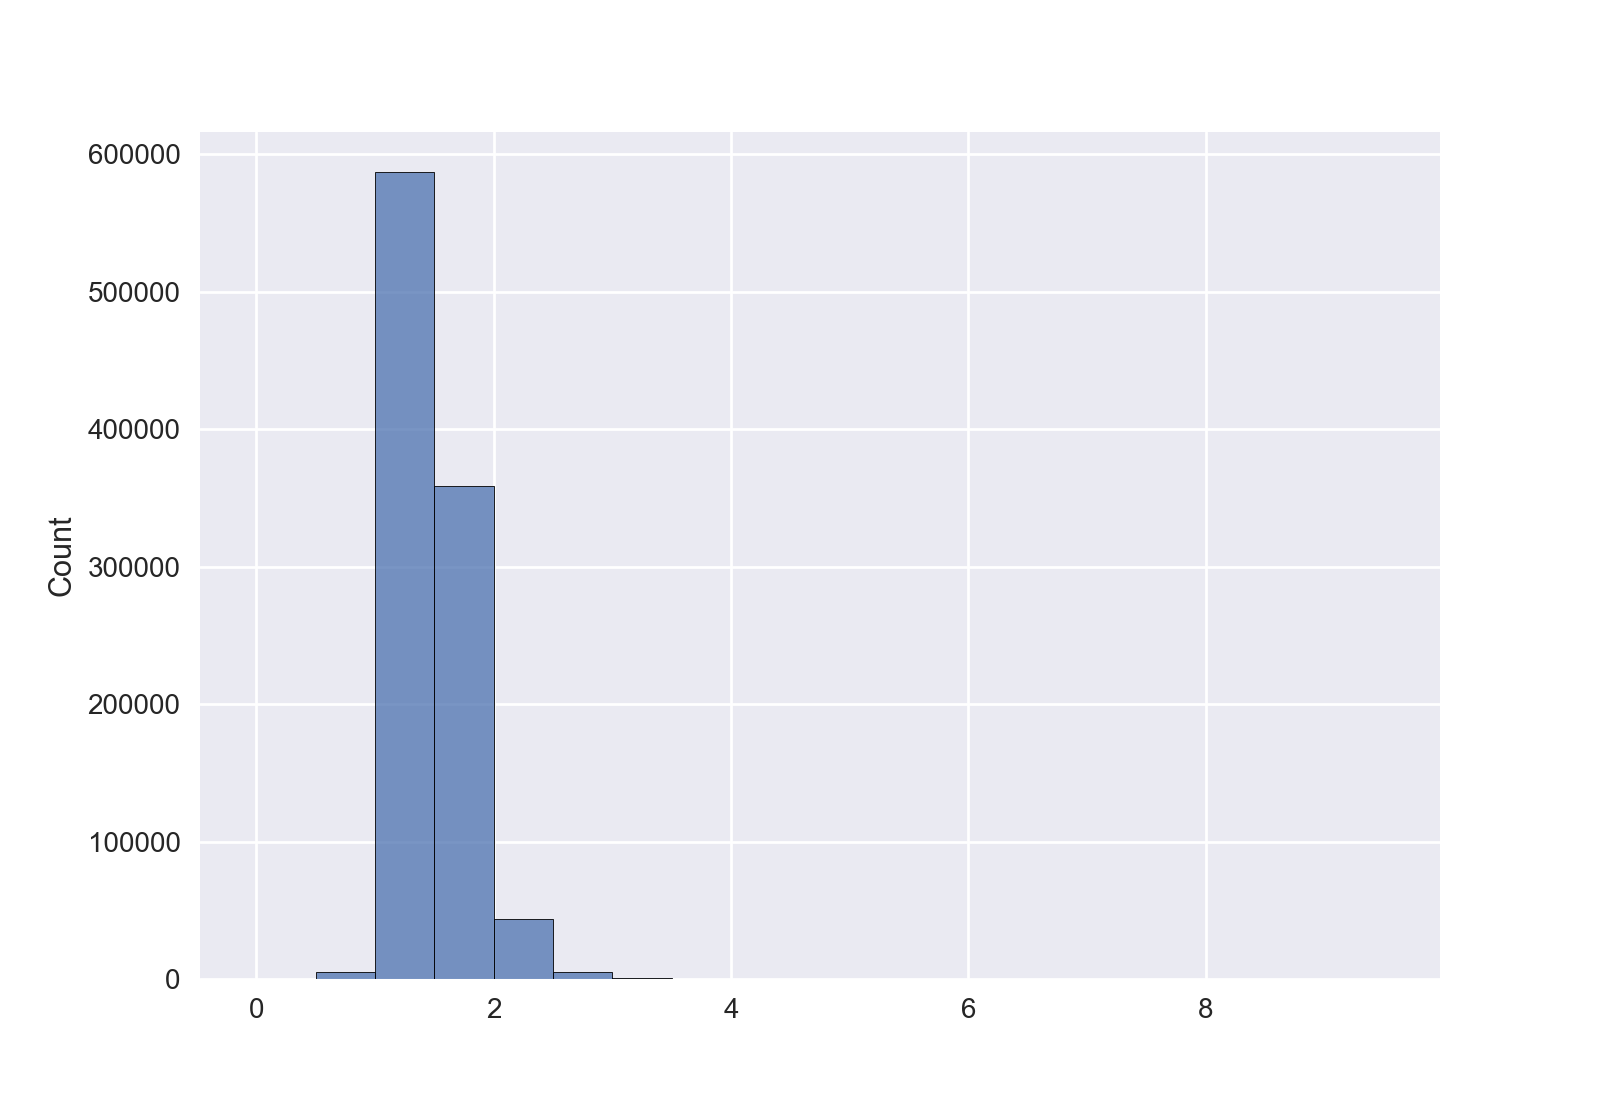

<IPython.core.display.Javascript object>

In [60]:
plt.figure()
sns.histplot(
    product_dataset.products.height / product_dataset.products.width,
    bins=np.arange(0, 10, 0.5),
)
plt.show()

<IPython.core.display.Javascript object>


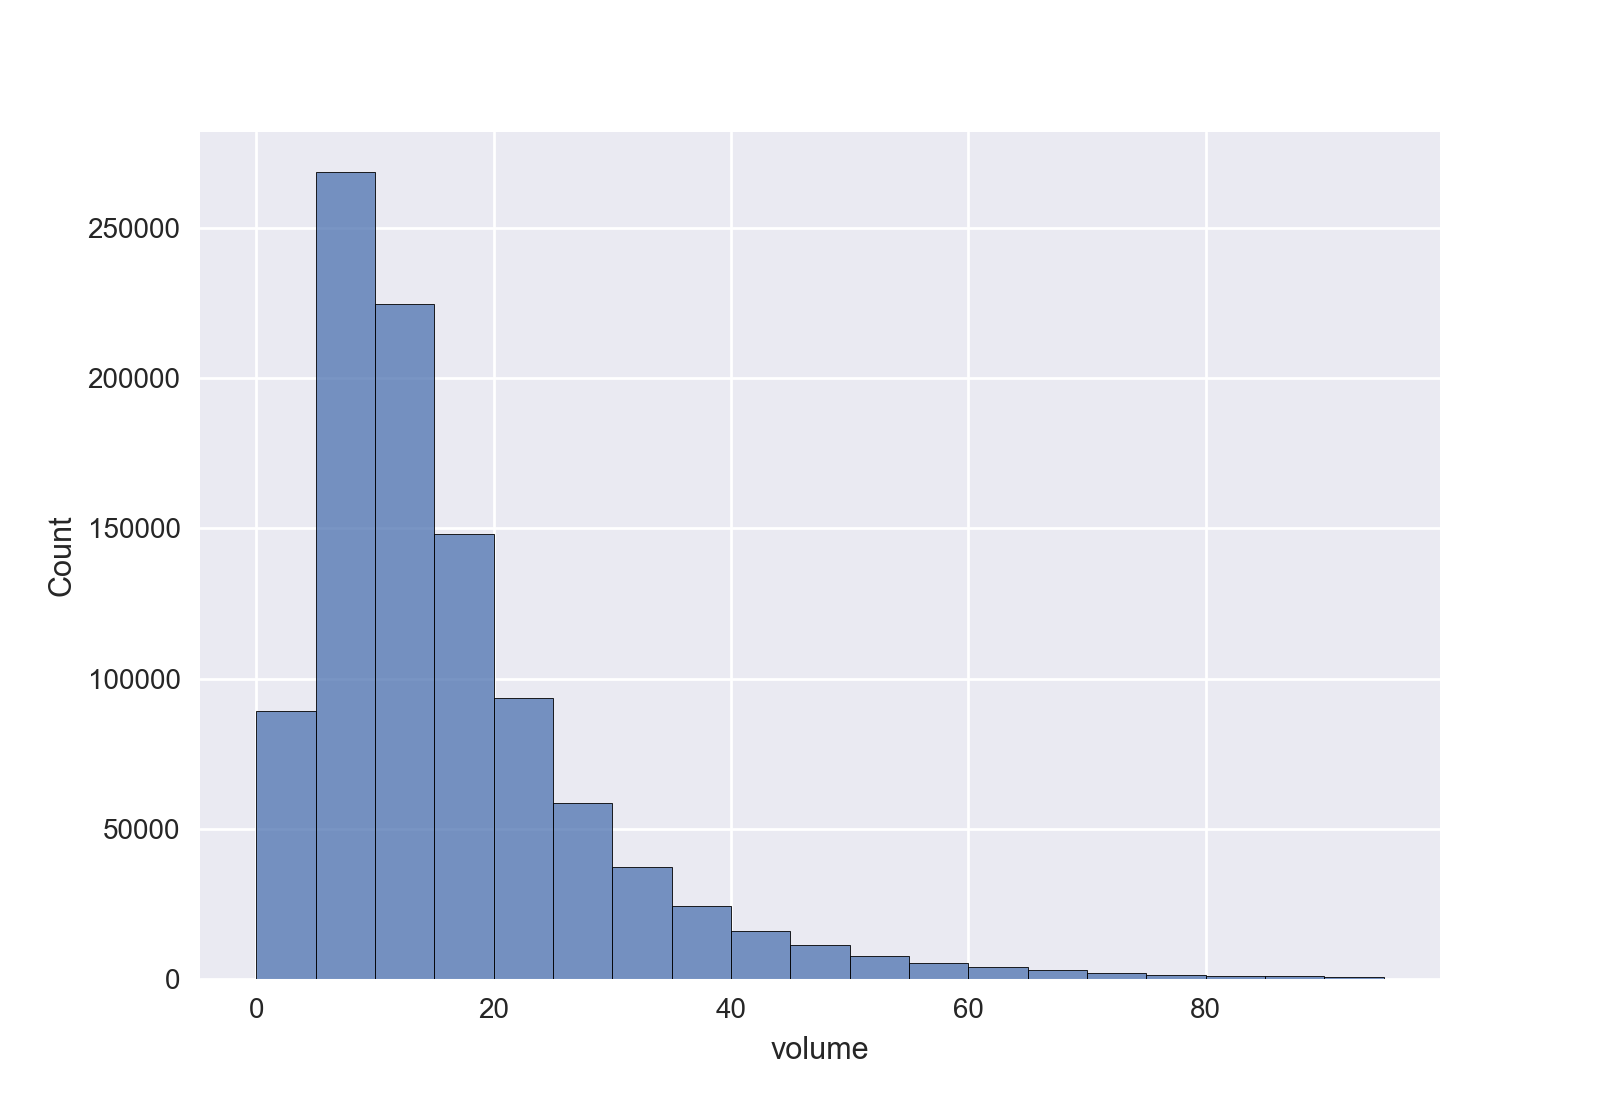

<IPython.core.display.Javascript object>

In [61]:
plt.figure()
sns.histplot(product_dataset.products.volume / 1e6, bins=np.arange(0, 100, 5))
plt.show()

<IPython.core.display.Javascript object>


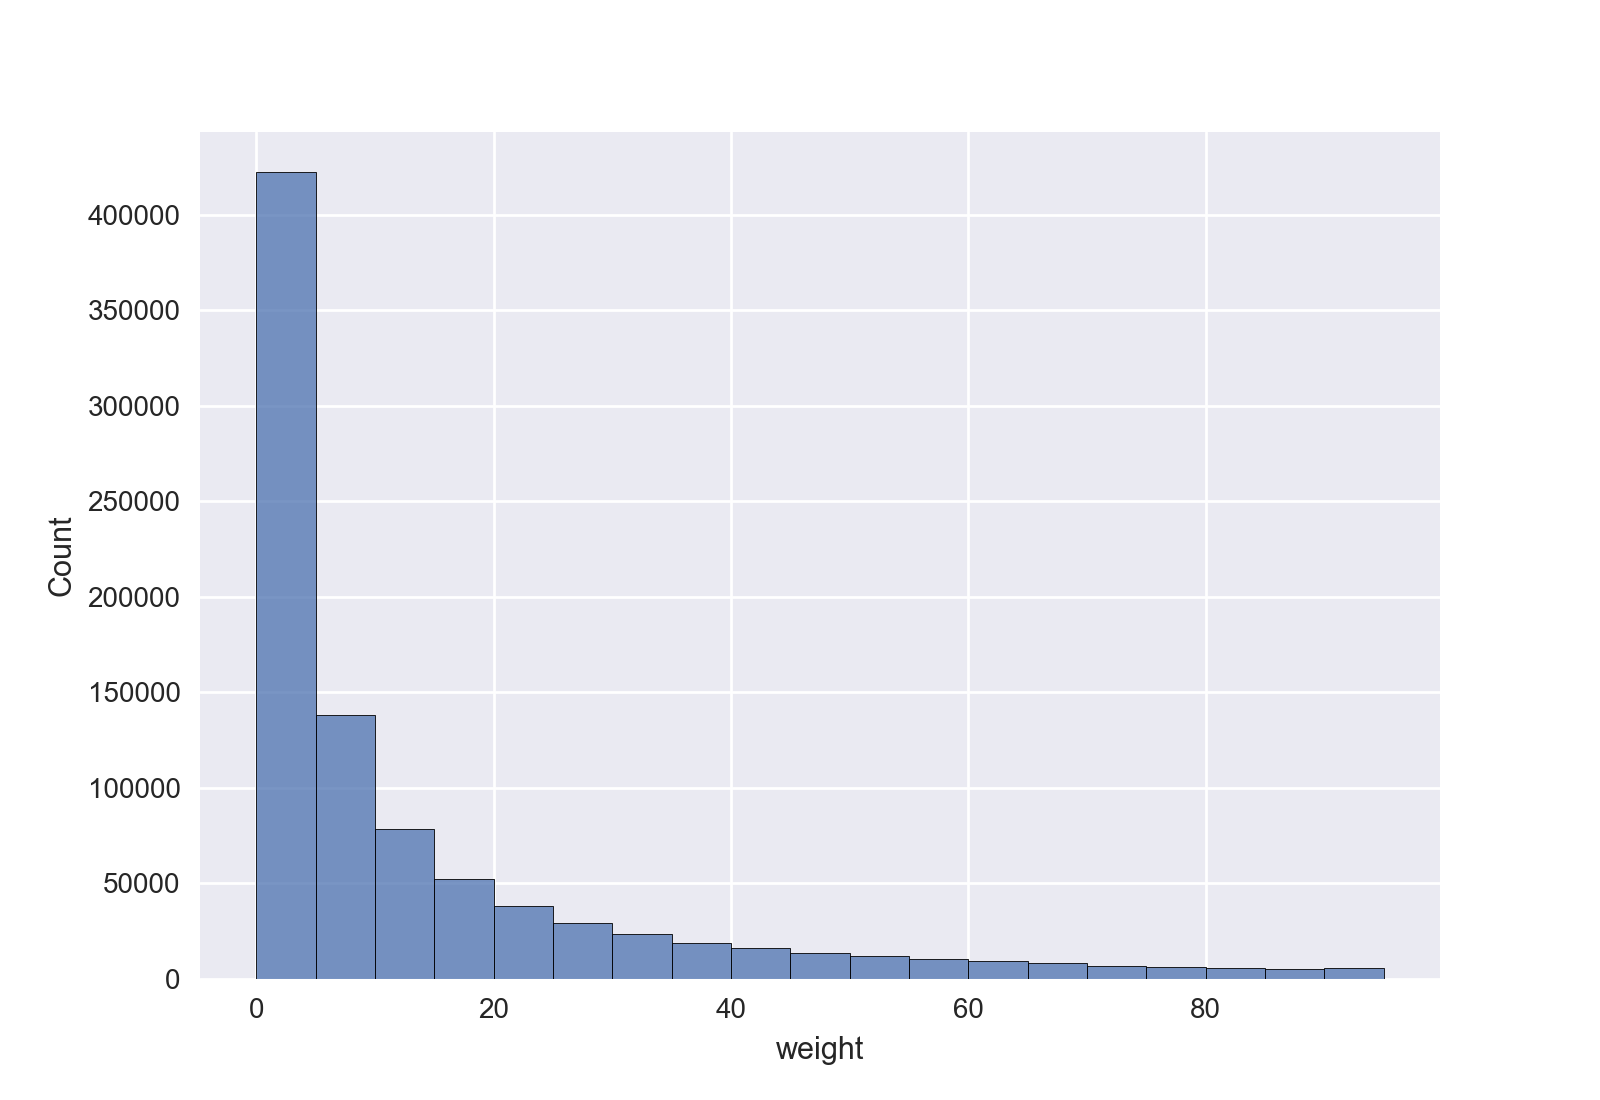

<IPython.core.display.Javascript object>

In [62]:
plt.figure()
sns.histplot(product_dataset.products.weight, bins=np.arange(0, 100, 5))
plt.show()

### Order

In [6]:
ordered_products = 10
order = product_dataset.get_order(ordered_products)
# order product_dataset.get_dummy_order(ordered_products)
order.head()

,id,width,depth,height,weight,volume
0,329365,232,494,441,57,50542128
1,64820,343,263,411,14,37075899
2,787201,294,136,440,16,17592960
3,321879,180,57,234,3,2400840
4,718315,176,100,225,4,3960000


<IPython.core.display.Javascript object>

## Martello's lower bounds

In [23]:
utils.get_l0_lb(order, config.PALLET_DIMS)

5.0

<IPython.core.display.Javascript object>

In [46]:
utils.get_l1_lb(order, config.PALLET_DIMS)

(0, 0, 0, 0)

<IPython.core.display.Javascript object>

In [49]:
utils.get_l2_lb(order, config.PALLET_DIMS)

250000it [17:30, 237.93it/s]
243500it [16:43, 242.57it/s]
243500it [16:40, 243.47it/s]


(5.0, 5.0, 5.0, 5.0)

<IPython.core.display.Javascript object>

## Baseline

In [8]:
bl_layer_pool = main.baseline_procedure(order)
bl_layer_pool.to_dataframe()

Generating vertical superitems: 100%|██████████| 1/1 [00:00<00:00, 16710.37it/s]


Items not covered: 0/10


,item,x,y,z,width,depth,height,layer
0,0,637,0,0,232,494,441,0
1,1,294,0,0,343,263,411,0
2,2,0,0,0,294,136,440,0
3,3,0,136,0,180,57,234,0
4,4,0,263,0,176,100,225,0
5,5,0,363,0,173,179,248,0
6,6,0,542,0,202,210,349,0
7,7,202,494,0,366,256,654,0
8,8,637,494,0,277,192,416,0
9,9,914,0,0,286,162,450,0


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


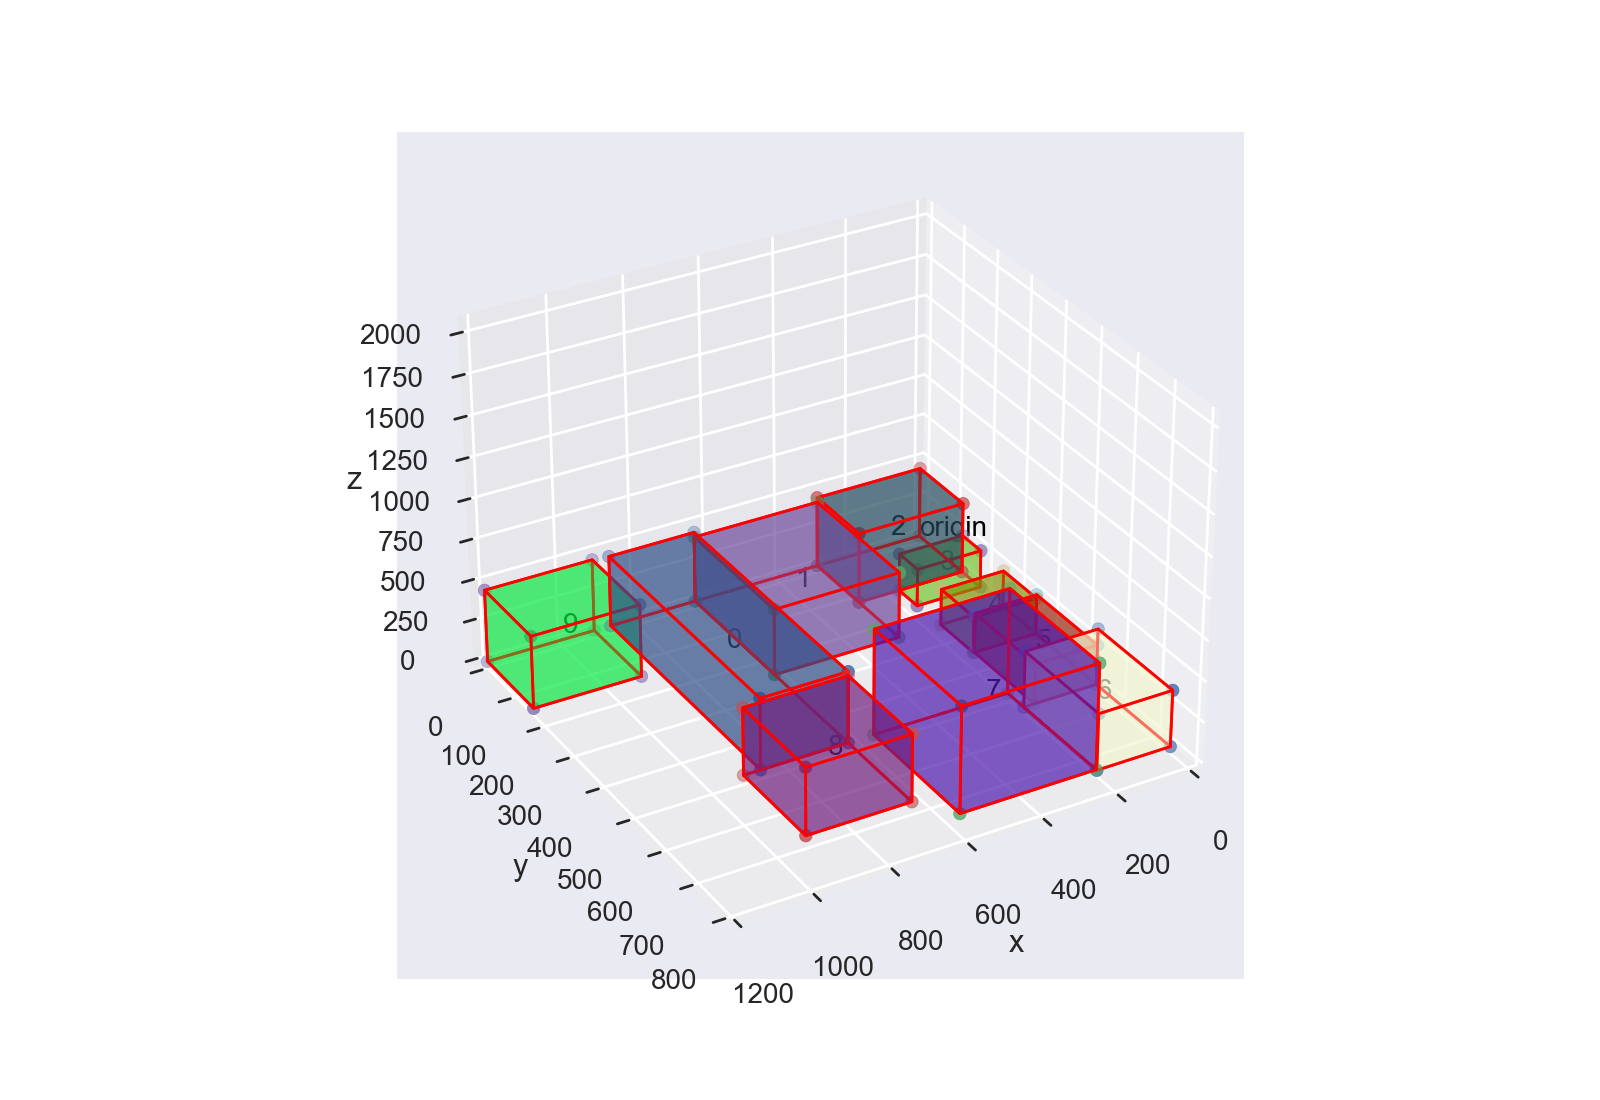

<IPython.core.display.Javascript object>

In [10]:
bl_bin_pool = bins.BinPool(bl_layer_pool, config.PALLET_DIMS)
bl_bin_pool.plot()

## Maxrects

Generating vertical superitems: 100%|██████████████████████████████████████████████████████████| 17/17 [00:00<?, ?it/s]

Height group 1/4


,item,x,y,z,width,depth,height,layer
0,33,0,0,0,431,256,400,0
1,44,431,0,0,258,354,400,0
2,11,0,256,0,203,375,400,0
3,3,203,256,0,175,357,400,0
4,21,203,613,0,323,144,400,0
5,13,0,631,0,198,168,400,0
6,17,378,354,0,326,232,400,0
7,18,526,586,0,341,212,400,0
8,19,689,0,0,261,283,400,0
9,15,704,283,0,288,253,400,0


Items not covered: 0/50


<IPython.core.display.Javascript object>


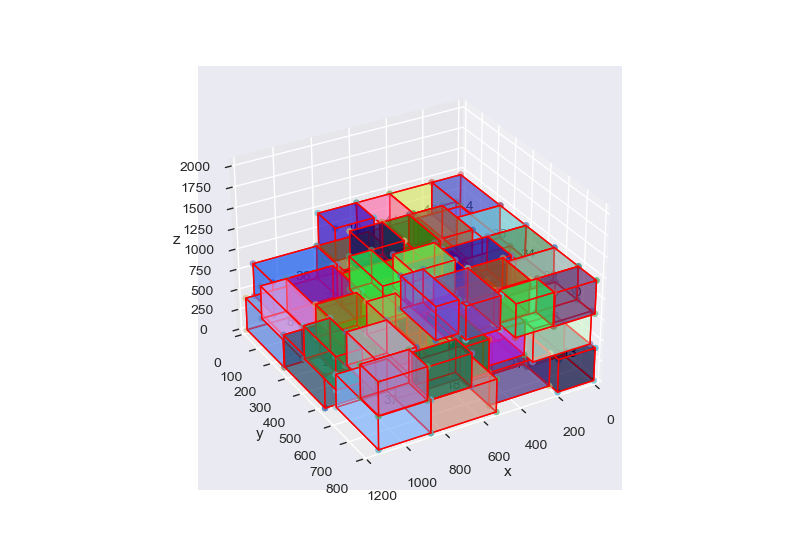

<IPython.core.display.Javascript object>

In [29]:
mr_layer_pool, _ = main.column_generation_procedure(order, use_cg=False)
mr_layer_pool.to_dataframe()

In [ ]:
mr_bin_pool = bins.BinPool(mr_layer_pool, config.PALLET_DIMS)
mr_bin_pool.plot()

## Column generation

Generating vertical superitems: 100%|███████████████████████████████████████████████| 17/17 [00:00<00:00, 32395.81it/s]

Height group 1/4


,item,x,y,z,width,depth,height,layer
0,0,0,0,0,200,94,400,0
1,1,0,0,0,152,322,400,1
2,2,0,0,0,269,210,400,2
3,3,0,0,0,175,357,400,3
4,4,0,0,0,163,244,400,4
5,5,0,0,0,144,195,400,5
6,6,0,0,0,118,209,400,6
7,7,0,0,0,180,189,400,7
8,8,0,0,0,232,257,400,8
9,9,0,0,0,221,124,400,9


Iteration 1/100
Solving RMP...
RMP objective: 20000.0
Duals: [400. 400. 400. 400. 400. 400. 400. 400. 400. 400. 400. 400. 400. 400.
 400. 400. 400. 400. 400. 400. 400. 400. 400. 400. 400. 400. 400. 400.
 400. 400. 400. 400. 400. 400. 400. 400. 400. 400. 400. 400. 400. 400.
 400. 400. 400. 400. 400. 400. 400. 400.]
RMP time: 3.017
Alpha: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
Solving SP (no placement)...
SP no placement time: 5.2763500000000004e-05
Reduced cost: -11600.0
FEASIBILITY:  30
Solving SP (no placement)...
Adding feasibility constraint: num selected <= 29
SP no placement time: 1.56095e-05
Reduced cost: -11200.0
FEASIBILITY:  29
Solving SP (no placement)...
Adding feasibility constraint: num selected <= 28
SP no placement time: 1.2257200000000002e-05
Reduced cost: -1080

,item,x,y,z,width,depth,height
0,36,0,0,0,338,136,400
1,23,338,0,0,245,183,400
2,20,0,136,0,219,192,400
3,6,219,136,0,118,209,400
4,46,0,328,0,213,188,400
5,4,0,516,0,163,244,400
6,48,163,516,0,134,275,400
7,45,213,345,0,235,153,400
8,29,337,183,0,256,133,400
9,24,583,0,0,206,178,400


Iteration 2/100
Solving RMP...
RMP objective: 10400.0
Duals: [400. 400. 400. 400.   0.   0.   0.   0. 400.   0.   0. 400.   0.   0.
   0. 400. 400. 400. 400. 400.   0. 400. 400.   0. 400.   0. 400.   0.
 400.   0.   0. 400. 400. 400.   0. 400.   0. 400.   0. 400.   0.   0.
   0. 400. 400.   0.   0. 400.   0. 400.]
RMP time: 3.159
Alpha: [1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0]
Solving SP (no placement)...
SP no placement time: 1.9919297000000003e-05
Reduced cost: -7200.0
FEASIBILITY:  19
Solving SP (no placement)...
Adding feasibility constraint: num selected <= 18
SP no placement time: 1.6193535000000002e-05
Reduced cost: -6800.0
FEASIBILITY:  18
Solving SP (no placement)...
Adding feasibility constraint: num selected <= 17
SP no placement time: 2.0115634e-05
Reduced cost: 

,item,x,y,z,width,depth,height
0,33,0,0,0,431,256,400
1,44,431,0,0,258,354,400
2,32,0,256,0,239,308,400
3,28,239,256,0,187,266,400
4,37,239,522,0,265,261,400
5,35,0,564,0,239,152,400
6,49,426,354,0,429,79,400
7,39,689,0,0,263,262,400
8,47,855,262,0,276,242,400
9,43,952,0,0,187,152,400


Iteration 3/100
Solving RMP...
RMP objective: 5600.0
Duals: [  0. 400. 400. 400.   0.   0.   0.   0. 400.   0.   0. 400.   0.   0.
   0. 400. 400. 400. 400. 400.   0. 400. 400.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0. 400. 400.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.]
RMP time: 3.073
Alpha: [0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0]
Solving SP (no placement)...
SP no placement time: 1.0316824e-05
Reduced cost: -5200.0
FEASIBILITY:  14
Solving SP (no placement)...
Adding feasibility constraint: num selected <= 13
SP no placement time: 1.8518517000000002e-05
Reduced cost: -4800.0
FEASIBILITY:  13
Solving SP (no placement)...
Adding feasibility constraint: num selected <= 12
SP no placement time: 5.175664e-06
Reduced cost: -4400.

,item,x,y,z,width,depth,height
0,11,0,0,0,203,375,400
1,17,0,375,0,326,232,400
2,21,0,607,0,323,144,400
3,35,323,607,0,239,152,400
4,19,203,0,0,261,283,400
5,22,203,283,0,225,92,400
6,18,326,375,0,341,212,400
7,16,562,587,0,311,201,400
8,15,873,0,0,288,253,400
9,3,667,0,0,175,357,400


Iteration 4/100
Solving RMP...
RMP objective: 2000.0
Duals: [  0. 400. 400.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0. 400.
   0.   0.   0. 400.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0. 400.]
RMP time: 3.156
Alpha: [0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0]
Solving SP (no placement)...
SP no placement time: 1.8501964e-05
Reduced cost: -1600.0


,item,x,y,z,width,depth,height
0,17,0,0,0,326,232,400
1,2,0,232,0,269,210,400
2,1,0,442,0,152,322,400
3,49,152,442,0,429,79,400
4,13,269,232,0,198,168,400


Iteration 5/100
Solving RMP...
RMP objective: 1600.0
Duals: [  0.   0. 400.   0.   0.   0.   0.   0.   0.   0.   0. 400.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0. 400.   0.   0.   0.
 400.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.]
RMP time: 3.281
Alpha: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0]
Solving SP (no placement)...
SP no placement time: 9.824919000000002e-06
Reduced cost: -1200.0


,item,x,y,z,width,depth,height
0,11,0,0,0,203,375,400
1,2,0,375,0,269,210,400
2,24,0,585,0,206,178,400
3,28,203,0,0,187,266,400


Iteration 6/100
Solving RMP...
RMP objective: 1600.0
Duals: [  0. 400.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0. 400.   0.
   0.   0.   0.   0. 400.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0. 400.   0.   0.   0.   0.   0.]
RMP time: 3.314
Alpha: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0]
Solving SP (no placement)...
SP no placement time: 5.455545e-06
Reduced cost: -1200.0


,item,x,y,z,width,depth,height
0,44,0,0,0,258,354,400
1,18,0,354,0,341,212,400
2,12,0,566,0,116,209,400
3,1,258,0,0,152,322,400


Iteration 7/100
Solving RMP...
RMP objective: 1600.0
Duals: [  0.   0. 400.   0.   0.   0.   0.   0. 400. 400.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0. 400.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.]
RMP time: 3.378
Alpha: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0]
Solving SP (no placement)...
SP no placement time: 7.1400260000000005e-06
Reduced cost: -1200.0


,item,x,y,z,width,depth,height
0,32,0,0,0,239,308,400
1,8,0,308,0,232,257,400
2,2,0,565,0,269,210,400
3,9,232,308,0,221,124,400


Iteration 8/100
Solving RMP...
RMP objective: 1600.0
Duals: [  0.   0. 400.   0.   0.   0. 400.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0. 400.   0.   0.   0.   0. 400.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.]
RMP time: 3.426
Alpha: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0]
Solving SP (no placement)...
SP no placement time: 5.389001e-06
Reduced cost: -1200.0


,item,x,y,z,width,depth,height
0,2,0,0,0,269,210,400
1,26,0,210,0,289,188,400
2,21,269,0,0,323,144,400
3,6,0,398,0,118,209,400


Iteration 9/100
Solving RMP...
RMP objective: 1600.0
Duals: [0.0000000e+00 4.4408921e-14 4.0000000e+02 4.0000000e+02 0.0000000e+00
 0.0000000e+00 4.4408921e-14 0.0000000e+00 0.0000000e+00 4.4408921e-14
 0.0000000e+00 0.0000000e+00 4.0000000e+02 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 4.4408921e-14
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 4.0000000e+02 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00]
RMP time: 3.488
Alpha: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 

,item,x,y,z,width,depth,height
0,3,0,0,0,175,357,400
1,2,0,357,0,269,210,400
2,24,0,567,0,206,178,400
3,43,206,567,0,187,152,400
4,1,175,0,0,152,322,400
5,9,269,322,0,221,124,400
6,6,327,0,0,118,209,400
7,12,445,0,0,116,209,400


Iteration 10/100
Solving RMP...
RMP objective: 1600.0
Duals: [  0.   0. 400.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0. 400.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0. 400.
   0.   0.   0.   0.   0. 400.   0.   0.]
RMP time: 3.486
Alpha: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0]
Solving SP (no placement)...
SP no placement time: 1.7645861000000003e-05
Reduced cost: -1200.0


,item,x,y,z,width,depth,height
0,47,0,0,0,276,242,400
1,2,0,242,0,269,210,400
2,41,0,452,0,182,153,400
3,22,0,605,0,225,92,400


Iteration 11/100
Solving RMP...
RMP objective: 1600.0
Duals: [  0.   0. 400.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0. 400.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0. 400. 400.   0.
   0.   0.   0.   0.   0.   0.   0.   0.]
RMP time: 3.609
Alpha: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
Solving SP (no placement)...
SP no placement time: 5.547415e-06
Reduced cost: -1200.0


,item,x,y,z,width,depth,height
0,39,0,0,0,263,262,400
1,16,0,262,0,311,201,400
2,2,263,0,0,269,210,400
3,40,0,463,0,243,138,400


Iteration 12/100
Solving RMP...
RMP objective: 1600.0
Duals: [  0.   0. 400.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0. 400.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0. 400.   0. 400.   0.   0.   0.]
RMP time: 3.713
Alpha: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0]
Solving SP (no placement)...
SP no placement time: 3.2760680000000002e-06
Reduced cost: -1200.0


,item,x,y,z,width,depth,height
0,44,0,0,0,258,354,400
1,15,0,354,0,288,253,400
2,46,0,607,0,213,188,400
3,2,258,0,0,269,210,400


Iteration 13/100
Solving RMP...
RMP objective: 1600.0
Duals: [  0.   0. 400.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0. 400.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0. 400.   0.   0.   0.   0.   0.   0. 400.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.]
RMP time: 4.031
Alpha: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
Solving SP (no placement)...
SP no placement time: 1.2776534e-05
Reduced cost: -1200.0


,item,x,y,z,width,depth,height
0,18,0,0,0,341,212,400
1,37,341,0,0,265,261,400
2,2,0,212,0,269,210,400
3,30,0,422,0,222,98,400


Iteration 14/100
Solving RMP...
RMP objective: 1600.0
Duals: [0.00000000e+00 1.33333333e+02 2.66666667e+02 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 1.33333333e+02 0.00000000e+00 0.00000000e+00 1.33333333e+02
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 1.33333333e+02 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 4.44089210e-14 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 2.66666667e+02 0.00000000e+00 0.00000000e+00
 0.00000000e+00 1.33333333e+02 0.00000000e+00 0.00000000e+00
 1.33333333e+02 1.33333333e+02 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 1.33333333e+02 0.00000000e+00
 0.00000000e+00 0.00000000e+00]
RMP time: 3.814
Alpha: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0

,item,x,y,z,width,depth,height
0,33,0,0,0,431,256,400
1,11,431,0,0,203,375,400
2,37,0,256,0,265,261,400
3,1,265,256,0,152,322,400
4,8,0,517,0,232,257,400
5,2,232,578,0,269,210,400
6,26,417,375,0,289,188,400
7,21,501,563,0,323,144,400
8,46,634,0,0,213,188,400
9,40,634,188,0,243,138,400


Iteration 15/100
Solving RMP...
RMP objective: 1600.0
Duals: [  0.   0. 400.   0. 400.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0. 400.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0. 400.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.]
RMP time: 3.892
Alpha: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
Solving SP (no placement)...
SP no placement time: 1.4226377e-05
Reduced cost: -1200.0


,item,x,y,z,width,depth,height
0,19,0,0,0,261,283,400
1,2,0,283,0,269,210,400
2,31,261,0,0,284,194,400
3,4,0,493,0,163,244,400


Iteration 16/100
Solving RMP...
RMP objective: 1600.0
Duals: [  0.         114.28571429 285.71428571   0.           0.
   0.           0.           0.           0.           0.
   0.           0.           0.           0.           0.
   0.          57.14285714   0.         114.28571429 114.28571429
   0.           0.         114.28571429   0.           0.
   0.           0.           0.         114.28571429   0.
   0.           0.         114.28571429   0.           0.
   0.           0.           0.           0.          57.14285714
   0.           0.           0.           0.         114.28571429
   0.           0.           0.         400.           0.        ]
RMP time: 3.967
Alpha: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.

,item,x,y,z,width,depth,height
0,44,0,0,0,258,354,400
1,19,0,354,0,261,283,400
2,22,0,637,0,225,92,400
3,32,258,0,0,239,308,400
4,18,261,308,0,341,212,400
5,39,497,0,0,263,262,400
6,16,261,520,0,311,201,400
7,2,572,520,0,269,210,400
8,28,760,0,0,187,266,400
9,1,841,266,0,152,322,400


Iteration 17/100
Solving RMP...
RMP objective: 1600.0
Duals: [  0. 400.   0.   0.   0.   0.   0. 400.   0.   0.   0.   0.   0.   0.
   0. 400.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0. 400.   0.   0.]
RMP time: 4.005
Alpha: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
Solving SP (no placement)...
SP no placement time: 4.499937e-06
Reduced cost: -1200.0


,item,x,y,z,width,depth,height
0,15,0,0,0,288,253,400
1,47,0,253,0,276,242,400
2,7,0,495,0,180,189,400
3,1,276,253,0,152,322,400


Iteration 18/100
Solving RMP...
RMP objective: 1555.5555555555557
Duals: [222.22222222 177.77777778 177.77777778  44.44444444   0.
   0.           0.           0.          44.44444444   0.
   0.           0.           0.           0.           0.
 222.22222222   0.          44.44444444   0.          44.44444444
   0.           0.           0.           0.           0.
   0.           0.           0.           0.           0.
   0.         177.77777778   0.           0.           0.
   0.           0.           0.           0.           0.
   0.           0.           0.           0.           0.
 400.           0.           0.           0.           0.        ]
RMP time: 4.084
Alpha: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.7777777777777778, 0.2222222222222222, 0.0, 0

,item,x,y,z,width,depth,height
0,17,0,0,0,326,232,400
1,19,0,232,0,261,283,400
2,15,0,515,0,288,253,400
3,8,261,232,0,232,257,400
4,2,326,0,0,269,210,400
5,31,288,489,0,284,194,400
6,0,288,683,0,200,94,400
7,45,493,210,0,235,153,400
8,3,572,363,0,175,357,400
9,1,728,0,0,152,322,400


Iteration 19/100
Solving RMP...
RMP objective: 1466.6666666666665
Duals: [  0.          66.66666667 200.           0.           0.
   0.          66.66666667   0.           0.           0.
   0.         133.33333333   0.           0.           0.
 133.33333333 133.33333333   0.           0.           0.
   0.           0.           0.         133.33333333   0.
   0.           0.           0.           0.           0.
 200.           0.           0.           0.           0.
   0.           0.           0.           0.           0.
   0.           0.           0.          66.66666667   0.
   0.           0.         200.           0.         133.33333333]
RMP time: 4.094
Alpha: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.6666666666666666, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,

,item,x,y,z,width,depth,height
0,11,0,0,0,203,375,400
1,15,0,375,0,288,253,400
2,49,0,628,0,429,79,400
3,47,203,0,0,276,242,400
4,30,203,242,0,222,98,400
5,16,288,340,0,311,201,400
6,2,429,541,0,269,210,400
7,1,479,0,0,152,322,400
8,23,599,322,0,245,183,400
9,43,698,505,0,187,152,400


Iteration 20/100
Solving RMP...
RMP objective: 1400.0
Duals: [  0.   0. 200.   0.   0.   0.   0. 400.   0.   0.   0.   0.   0.   0.
   0.   0.   0. 200.   0.   0.   0. 200.   0.   0.   0.   0.   0.   0.
 200.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0. 200.   0.   0.   0.   0.   0.   0.]
RMP time: 4.146
Alpha: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.75, 0.75, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.25, 0.0, 0.25, 0.0, 0.25, 0.25]
RMP: solution not feasible (at least one alpha value is not binary)
Solving SP (no placement)...
SP no placement time: 1.4327570000000001e-05
Reduced cost: -1000.0


,item,x,y,z,width,depth,height
0,17,0,0,0,326,232,400
1,2,0,232,0,269,210,400
2,28,0,442,0,187,266,400
3,21,187,442,0,323,144,400
4,7,269,232,0,180,189,400
5,43,326,0,0,187,152,400


Iteration 21/100
Solving RMP...
RMP objective: 1400.0
Duals: [  0.   0. 200. 100. 200.   0.   0. 100.   0.   0.   0.   0.   0. 100.
   0.   0.   0. 100. 200.   0.   0.   0.   0.   0.   0.   0. 200.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0. 200.   0.   0.]
RMP time: 4.242
Alpha: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.75, 0.75, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.25, 0.0, 0.25, 0.0, 0.25, 0.25, -0.0]
RMP: solution not feasible (at least one alpha value is not binary)
Solving SP (no placement)...
SP no placement time: 7.5722690000000005e-06
Reduced cost: -1000.0


,item,x,y,z,width,depth,height
0,17,0,0,0,326,232,400
1,18,0,232,0,341,212,400
2,2,326,0,0,269,210,400
3,47,0,444,0,276,242,400
4,26,276,444,0,289,188,400
5,13,276,632,0,198,168,400
6,7,341,210,0,180,189,400
7,3,565,210,0,175,357,400
8,4,740,0,0,163,244,400


Iteration 22/100
Solving RMP...
RMP objective: 1400.0
Duals: [  0. 200.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0. 200. 200.
   0.   0.   0.   0.   0.   0.   0. 200. 200.   0.   0.   0.   0.   0.
   0.   0.   0. 200.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0. 200.   0.   0.]
RMP time: 4.292
Alpha: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.75, 0.75, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.25, 0.0, 0.25, 0.0, 0.25, 0.25, 0.0, 0.0]
RMP: solution not feasible (at least one alpha value is not binary)
Solving SP (no placement)...
SP no placement time: 8.028179e-06
Reduced cost: -1000.0


,item,x,y,z,width,depth,height
0,47,0,0,0,276,242,400
1,31,0,242,0,284,194,400
2,21,276,0,0,323,144,400
3,22,276,144,0,225,92,400
4,1,0,436,0,152,322,400
5,13,152,436,0,198,168,400
6,12,501,144,0,116,209,400


Iteration 23/100
Solving RMP...
RMP objective: 1400.0
Duals: [ 80. 200.   0. 120.   0.   0.   0.   0.   0.   0.   0.   0.  40.  40.
   0.   0.   0.   0. 160.   0.   0. 120.   0.   0.   0.   0.  80.   0.
   0.   0.   0.   0.  40.   0.   0.   0. 320.   0.   0.   0.   0.   0.
   0.  40.   0.   0.   0.   0.   0. 160.]
RMP time: 4.342
Alpha: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.75, 0.75, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.25, 0.0, 0.25, 0.0, 0.25, 0.25, 0.0, 0.0, 0.0]
RMP: solution not feasible (at least one alpha value is not binary)
Solving SP (no placement)...
SP no placement time: 1.3430338e-05
Reduced cost: -1002.0


,item,x,y,z,width,depth,height
0,32,0,0,0,239,308,400
1,18,0,308,0,341,212,400
2,26,239,0,0,289,188,400
3,49,239,188,0,429,79,400
4,21,528,0,0,323,144,400
5,3,851,0,0,175,357,400
6,1,668,144,0,152,322,400
7,12,1026,0,0,116,209,400
8,36,820,357,0,338,136,400
9,13,341,466,0,198,168,400


Iteration 24/100
Solving RMP...
RMP objective: 1400.0000000000002
Duals: [  0.          14.28571429 185.71428571  85.71428571   0.
   0.           0.           0.           0.           0.
 328.57142857   0.           0.          57.14285714   0.
   0.           0.          57.14285714   0.           0.
   0.          57.14285714 200.           0.          14.28571429
   0.           0.           0.           0.           0.
   0.          57.14285714   0.         142.85714286   0.
   0.           0.           0.           0.           0.
   0.           0.           0.         100.           0.
   0.           0.          14.28571429   0.          85.71428571]
RMP time: 4.339
Alpha: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.75, 0.7500000000000001, 0.0, 0.0, 0.0, 0.0, 0.0, 

,item,x,y,z,width,depth,height
0,33,0,0,0,431,256,400
1,17,431,0,0,326,232,400
2,47,757,0,0,276,242,400
3,1,1033,0,0,152,322,400
4,3,431,232,0,175,357,400
5,2,0,256,0,269,210,400
6,31,0,466,0,284,194,400
7,49,0,660,0,429,79,400
8,21,429,589,0,323,144,400
9,24,606,242,0,206,178,400


Iteration 25/100
Solving RMP...
RMP objective: 1373.3333333333333
Duals: [ 26.66666667 173.33333333   0.           0.           0.
   0.           0.           0.           0.         213.33333333
   0.          13.33333333   0.           0.           0.
  93.33333333   0.         106.66666667 186.66666667   0.
 186.66666667   0.           0.           0.           0.
   0.           0.           0.           0.           0.
   0.           0.           0.           0.           0.
   0.           0.         213.33333333   0.          40.
   0.           0.           0.          13.33333333   0.
   0.           0.         106.66666667   0.           0.        ]
RMP time: 4.447
Alpha: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.7333333333333334, 0.6333333333333334, 0.0, 0.0, 0

,item,x,y,z,width,depth,height
0,11,0,0,0,203,375,400
1,17,0,375,0,326,232,400
2,20,0,607,0,219,192,400
3,43,219,607,0,187,152,400
4,15,203,0,0,288,253,400
5,0,203,253,0,200,94,400
6,18,326,347,0,341,212,400
7,9,406,559,0,221,124,400
8,37,491,0,0,265,261,400
9,39,667,261,0,263,262,400


Iteration 26/100
Solving RMP...
RMP objective: 1363.934426229508
Duals: [ 13.1147541    0.         163.93442623  72.13114754   0.
   0.           0.           0.           0.           0.
   0.           0.           0.           0.           0.
 144.26229508   0.           6.55737705 111.47540984   0.
   0.          65.57377049   0.           0.           0.
   0.          45.90163934 400.          32.78688525   0.
   0.           0.           0.           0.           0.
   0.           0.         124.59016393   0.           0.
   0.           0.           0.           0.          91.80327869
   0.           0.           0.           0.          91.80327869]
RMP time: 4.543
Alpha: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.7213114754098361, 0.6229508196721312, 0.0, 0.0, 0.

,item,x,y,z,width,depth,height
0,44,0,0,0,258,354,400
1,17,0,354,0,326,232,400
2,18,0,586,0,341,212,400
3,15,258,0,0,288,253,400
4,49,258,253,0,429,79,400
5,2,546,0,0,269,210,400
6,26,326,332,0,289,188,400
7,37,341,520,0,265,261,400
8,28,606,520,0,187,266,400
9,21,615,332,0,323,144,400


Iteration 27/100
Solving RMP...
RMP objective: 1345.4545454545455
Duals: [7.27272727e+01 0.00000000e+00 1.45454545e+02 1.09090909e+02
 0.00000000e+00 4.00000000e+02 0.00000000e+00 0.00000000e+00
 7.27272727e+01 0.00000000e+00 0.00000000e+00 1.45454545e+02
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 6.66133815e-14 0.00000000e+00 3.63636364e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 3.63636364e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 1.81818182e+02 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 3.63636364e+01 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 1.09090909e+02
 0.00000000e+00 0.00000000e+00]
RMP time: 4.685
Alpha: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,

,item,x,y,z,width,depth,height
0,11,0,0,0,203,375,400
1,32,0,375,0,239,308,400
2,22,0,683,0,225,92,400
3,0,225,683,0,200,94,400
4,18,203,0,0,341,212,400
5,37,239,212,0,265,261,400
6,16,239,473,0,311,201,400
7,47,504,212,0,276,242,400
8,2,544,0,0,269,210,400
9,8,550,454,0,232,257,400


Iteration 28/100
Solving RMP...
RMP objective: 1340.8450704225352
Duals: [  0.         101.4084507   39.43661972   0.           0.
   0.           0.           0.           0.           0.
   0.          84.50704225   0.           0.         400.
 152.11267606   0.           0.          33.8028169    0.
   0.           0.         129.57746479   0.           0.
   0.         174.64788732   0.           0.           0.
   0.         107.04225352  90.14084507   0.           0.
   0.           0.           0.           0.           5.63380282
   0.           0.           0.           0.           0.
   0.           0.          22.53521127   0.           0.        ]
RMP time: 4.69
Alpha: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.6901408450704225, 0.5915492957746479, 0.0, 0.0, 0.

,item,x,y,z,width,depth,height
0,11,0,0,0,203,375,400
1,32,0,375,0,239,308,400
2,14,0,683,0,246,109,400
3,15,203,0,0,288,253,400
4,22,203,253,0,225,92,400
5,18,239,345,0,341,212,400
6,47,246,557,0,276,242,400
7,2,522,557,0,269,210,400
8,39,491,0,0,263,262,400
9,31,580,262,0,284,194,400


Iteration 29/100
Solving RMP...
RMP objective: 1337.3737373737374
Duals: [ 12.12121212 137.37373737   0.          56.56565657   0.
   0.           0.          96.96969697  28.28282828   0.
   0.           0.           0.           0.           0.
   0.         222.22222222  92.92929293   0.           0.
   0.           0.           0.           0.           0.
   0.         153.53535354   0.           0.           0.
   0.          72.72727273   0.           0.           0.
   0.           0.          80.80808081 303.03030303  36.36363636
   0.           0.           0.          40.4040404    4.04040404
   0.           0.           0.           0.           0.        ]
RMP time: 4.708
Alpha: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.6767676767676769, 0.595959595959596, 0.0,

,item,x,y,z,width,depth,height
0,44,0,0,0,258,354,400
1,17,0,354,0,326,232,400
2,16,0,586,0,311,201,400
3,31,311,586,0,284,194,400
4,37,258,0,0,265,261,400
5,39,326,261,0,263,262,400
6,8,523,0,0,232,257,400
7,26,589,257,0,289,188,400
8,0,589,445,0,200,94,400
9,7,755,0,0,180,189,400


Iteration 30/100
Solving RMP...
RMP objective: 1333.3333333333333
Duals: [5.55111512e-15 1.33333333e+02 0.00000000e+00 1.33333333e+02
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 6.66666667e+01 0.00000000e+00 0.00000000e+00 1.33333333e+02
 0.00000000e+00 0.00000000e+00 0.00000000e+00 6.66666667e+01
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 2.00000000e+02 0.00000000e+00 0.00000000e+00 1.11022302e-14
 6.66666667e+01 6.66666667e+01 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 4.00000000e+02 6.66666667e+01
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00]
RMP time: 4.844
Alpha: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,

,item,x,y,z,width,depth,height
0,33,0,0,0,431,256,400
1,11,431,0,0,203,375,400
2,32,0,256,0,239,308,400
3,3,239,256,0,175,357,400
4,43,0,564,0,187,152,400
5,0,187,613,0,200,94,400
6,15,414,375,0,288,253,400
7,8,634,0,0,232,257,400
8,31,866,0,0,284,194,400
9,28,866,194,0,187,266,400


Iteration 31/100
Solving RMP...
RMP objective: 1329.7935103244838
Duals: [ 76.69616519 112.09439528  17.69911504   0.           0.
   0.           0.           0.          49.55752212   0.
   0.          61.35693215   0.           0.           0.
   0.          57.81710914  31.85840708   0.         112.09439528
   0.          87.31563422   0.           0.           0.
 400.          71.97640118   0.          81.4159292    0.
   0.           0.          18.87905605   0.           0.
   0.           0.           0.           0.           0.
   0.           0.           0.           0.           0.
   0.           0.         117.99410029   0.          33.03834808]
RMP time: 4.871
Alpha: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.6592920353982301, 0.5766961651917405, 0.0, 0.0, 0

,item,x,y,z,width,depth,height
0,11,0,0,0,203,375,400
1,17,0,375,0,326,232,400
2,26,0,607,0,289,188,400
3,21,289,607,0,323,144,400
4,19,203,0,0,261,283,400
5,49,203,283,0,429,79,400
6,47,464,0,0,276,242,400
7,16,326,362,0,311,201,400
8,0,632,242,0,200,94,400
9,25,740,0,0,184,184,400


Iteration 32/100
Solving RMP...
RMP objective: 1328.1879194630872
Duals: [  0.           0.         128.18791946   0.         125.5033557
   0.           0.           0.          51.00671141   0.
   0.          46.30872483   0.           0.           0.
  40.26845638   3.3557047   34.22818792  22.81879195 146.30872483
   0.          55.70469799   0.           0.           0.
   0.          59.06040268   0.           0.         274.4966443
   0.           0.          84.56375839   0.           0.
   0.           0.          59.73154362   0.          14.76510067
   0.           0.           0.         177.85234899   0.
   0.           0.           4.02684564   0.           0.        ]
RMP time: 4.911
Alpha: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.6510067114093958, 0.5654362

,item,x,y,z,width,depth,height
0,11,0,0,0,203,375,400
1,17,0,375,0,326,232,400
2,26,0,607,0,289,188,400
3,21,289,607,0,323,144,400
4,19,203,0,0,261,283,400
5,32,326,283,0,239,308,400
6,15,464,0,0,288,253,400
7,37,565,253,0,265,261,400
8,2,752,0,0,269,210,400
9,4,1021,0,0,163,244,400


Iteration 33/100
Solving RMP...
RMP objective: 1319.893899204244
Duals: [ 26.52519894   3.18302387 116.71087533   0.           0.
   0.           0.           0.          63.66047745  11.67108753
   0.           0.           0.           0.           0.
 119.8938992  115.64986737  48.80636605  30.76923077  21.22015915
   0.           0.           0.           0.           0.
  76.39257294   0.           0.           0.           0.
   0.           0.           0.         186.73740053   0.
   0.         311.93633952  29.70822281   0.         112.4668435
   0.           0.           0.           0.           0.
   0.           0.          16.97612732   0.          27.5862069 ]
RMP time: 4.916
Alpha: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.9761273209549072, 0.6206896551724139, 0.

,item,x,y,z,width,depth,height
0,33,0,0,0,431,256,400
1,17,431,0,0,326,232,400
2,15,757,0,0,288,253,400
3,37,431,232,0,265,261,400
4,18,0,256,0,341,212,400
5,39,0,468,0,263,262,400
6,16,696,253,0,311,201,400
7,25,1007,253,0,184,184,400
8,8,696,454,0,232,257,400
9,2,928,454,0,269,210,400


Iteration 34/100
Solving RMP...
RMP objective: 1310.8108108108108
Duals: [  0.          59.45945946  51.35135135  62.16216216   0.
   8.10810811   0.          24.32432432   0.           0.
   0.          64.86486486 227.02702703   0.          59.45945946
  81.08108108  64.86486486   0.           0.         110.81081081
  45.94594595  16.21621622   0.           0.           0.
   0.           5.40540541   0.           0.           0.
   0.           0.           0.         132.43243243   0.
   0.           0.          70.27027027   0.           0.
   0.           0.           0.           0.         113.51351351
  35.13513514   0.          78.37837838   0.           0.        ]
RMP time: 5.02
Alpha: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.9628378378378377, 0.5625, 0.44087837837

,item,x,y,z,width,depth,height
0,33,0,0,0,431,256,400
1,44,431,0,0,258,354,400
2,11,0,256,0,203,375,400
3,12,203,256,0,116,209,400
4,19,203,465,0,261,283,400
5,15,464,354,0,288,253,400
6,37,689,0,0,265,261,400
7,47,752,261,0,276,242,400
8,16,752,503,0,311,201,400


Iteration 35/100
Solving RMP...
RMP objective: 1297.560975609756
Duals: [  0.          48.7804878   58.53658537 107.31707317   0.
 136.58536585   0.           0.          19.51219512 126.82926829
   0.          68.29268293   0.           0.           0.
  39.02439024   0.           0.           9.75609756 126.82926829
   0.          19.51219512   0.         136.58536585   0.
   0.          68.29268293   0.           0.           0.
   0.           0.           0.         117.07317073   0.
   9.75609756   0.           0.           0.         107.31707317
   0.           0.           0.           0.          48.7804878
   0.           0.           0.           0.          48.7804878 ]
RMP time: 5.05
Alpha: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.9593495934959348, 0.5447154471544

,item,x,y,z,width,depth,height
0,33,0,0,0,431,256,400
1,11,431,0,0,203,375,400
2,19,0,256,0,261,283,400
3,5,261,256,0,144,195,400
4,2,0,539,0,269,210,400
5,49,261,451,0,429,79,400
6,39,269,530,0,263,262,400
7,26,532,530,0,289,188,400
8,3,634,0,0,175,357,400
9,9,690,357,0,221,124,400


Iteration 36/100
Solving RMP...
RMP objective: 1296.6363636363637
Duals: [  0.          72.72727273  90.54545455   0.           0.
  81.36363636  37.           0.          89.09090909   0.
   0.          84.27272727  87.18181818   0.           0.
  19.90909091   0.           0.          53.45454545  49.90909091
 141.36363636  36.72727273   0.           0.           0.
   0.           0.           0.           0.           0.
   0.          77.81818182   1.27272727  26.63636364   0.
  66.63636364  53.09090909   0.           0.           0.
   0.           0.           0.          28.27272727 132.09090909
   0.           0.           0.           0.          67.27272727]
RMP time: 5.105
Alpha: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.9554545454545454, 0.535, 0.46499999999999997, 

,item,x,y,z,width,depth,height
0,44,0,0,0,258,354,400
1,11,0,354,0,203,375,400
2,19,203,354,0,261,283,400
3,21,203,637,0,323,144,400
4,18,258,0,0,341,212,400
5,36,258,212,0,338,136,400
6,8,464,348,0,232,257,400
7,49,596,212,0,429,79,400
8,2,599,0,0,269,210,400
9,31,868,0,0,284,194,400


Iteration 37/100
Solving RMP...
RMP objective: 1288.2282040980313
Duals: [ 85.33547609  55.76536762  32.46283648  10.76737646  14.78505424
   0.           0.           0.          64.28284452  82.92486943
   0.           0.          12.69586179   0.           0.
  66.69345119   0.           0.           0.          84.69264765
  58.17597429  20.89192447 152.67175573   0.           0.
   0.          75.37163519   0.           0.           0.
 231.41824026   0.           3.37484934 113.78063479   0.
   0.           0.          37.44475693   0.           0.
   0.           0.           0.           0.          71.03254319
   0.           0.          13.66010446   0.           0.        ]
RMP time: 5.145
Alpha: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.9433507432703898, 0.5335476094

,item,x,y,z,width,depth,height
0,33,0,0,0,431,256,400
1,44,431,0,0,258,354,400
2,19,0,256,0,261,283,400
3,1,261,256,0,152,322,400
4,8,0,539,0,232,257,400
5,2,232,578,0,269,210,400
6,26,413,354,0,289,188,400
7,15,501,542,0,288,253,400
8,37,689,0,0,265,261,400
9,22,689,261,0,225,92,400


Iteration 38/100
Solving RMP...
RMP objective: 1278.225616367322
Duals: [  0.         103.45542828  38.89124593  84.46707208   0.
   0.           0.           0.           0.           0.
   0.          35.30853722  47.32946778   0.           0.
  34.84655636  70.36251355   0.          56.13538868  15.56592655
   0.          39.19294772   0.          64.89416867   0.
   0.          23.70244661   0.          60.17065007 149.89864706
   0.           0.           0.          81.751756     0.
  64.12105784   0.          62.59369255   0.          55.41884693
   0.           0.           0.           0.           0.
 122.7737708   15.10394569  52.24154999   0.           0.        ]
RMP time: 5.259
Alpha: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.9378211474096072, 0.5186677980483665, 0

,item,x,y,z,width,depth,height
0,33,0,0,0,431,256,400
1,18,431,0,0,341,212,400
2,37,772,0,0,265,261,400
3,1,1037,0,0,152,322,400
4,39,431,212,0,263,262,400
5,16,694,261,0,311,201,400
6,3,1005,322,0,175,357,400
7,28,694,462,0,187,266,400
8,23,0,474,0,245,183,400
9,35,0,256,0,239,152,400


Iteration 39/100
Solving RMP...
RMP objective: 1273.45823848713
Duals: [  0.          16.38942392  77.86610634  59.62294986   0.
   0.           0.          74.92441487  48.46319967   0.
   0.           8.82040507  20.12957451   0.           0.
  72.73915835   0.74709625   0.          74.5648748  114.24502422
   0.           0.           0.          30.71966381   0.
   0.           0.           0.          79.58909706   0.
   0.           0.           0.          53.40337361   0.
  20.79729178   0.          16.89371389  85.38843168  36.5983774
   0.           0.           0.          60.97239246   0.
  10.67413763 178.16377751 113.02165412   0.          18.72409969]
RMP time: 5.529
Alpha: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.9300297671160918, 0.5123445981439326, 0.445631237

,item,x,y,z,width,depth,height
0,33,0,0,0,431,256,400
1,19,431,0,0,261,283,400
2,15,0,256,0,288,253,400
3,38,288,256,0,127,224,400
4,18,288,480,0,341,212,400
5,47,0,509,0,276,242,400
6,46,415,283,0,213,188,400
7,7,628,283,0,180,189,400
8,8,692,0,0,232,257,400
9,2,629,472,0,269,210,400


Iteration 40/100
Solving RMP...
RMP objective: 1271.6937958921774
Duals: [ 26.55011895  36.09992918  60.97689425  87.43015914   0.
   0.           0.           0.           0.           7.33911633
   0.          15.84048136  62.3619073    0.           0.
  65.98667046  60.75412992   0.           0.          77.6914835
   0.          66.91404808   0.           0.           0.
   0.           0.           0.           2.39955931   0.
  11.76292548   0.          42.75138168   0.           0.
  25.38302754   0.          35.01032101   0.         107.65812938
   0.         185.15832612  88.11298026  34.82871965  11.66849277
  45.26474452   0.          70.68651368   0.          43.06373602]
RMP time: 5.503
Alpha: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.9273473489228015, 0.50774529803

,item,x,y,z,width,depth,height
0,19,0,0,0,261,283,400
1,32,0,283,0,239,308,400
2,16,0,591,0,311,201,400
3,15,239,283,0,288,253,400
4,39,311,536,0,263,262,400
5,47,261,0,0,276,242,400
6,2,527,242,0,269,210,400
7,49,527,452,0,429,79,400
8,21,537,0,0,323,144,400
9,45,796,144,0,235,153,400


Iteration 41/100
Solving RMP...
RMP objective: 1266.6043363190538
Duals: [ 40.7181877   23.17267928  43.43165703   9.84302764   0.
   0.           0.           0.           0.           0.
   0.          75.64449741   0.           0.          14.86885598
  21.81045438  70.30927802  13.72882423  41.061812   113.4063535
   0.           0.          54.19575282  37.96596375   0.
   0.           0.         132.7190726   18.10163722   0.
   0.          73.92895955   0.          54.03362932   0.
   0.           0.          49.23128596   0.          36.32083012
 154.48625099   0.           0.          82.74692749   0.
  59.95985667   0.          15.56450141   0.          29.35404122]
RMP time: 5.463
Alpha: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.922024089226054, 0.5086689241232978, 0.

,item,x,y,z,width,depth,height
0,33,0,0,0,431,256,400
1,11,431,0,0,203,375,400
2,19,0,256,0,261,283,400
3,18,0,539,0,341,212,400
4,45,261,375,0,235,153,400
5,37,341,528,0,265,261,400
6,40,496,375,0,243,138,400
7,39,606,513,0,263,262,400
8,16,634,0,0,311,201,400
9,43,634,201,0,187,152,400


Iteration 42/100
Solving RMP...
RMP objective: 1259.815204689736
Duals: [  3.65182243  86.90533495  28.15592044  28.51896332   0.
 108.11611538   0.           0.           0.           1.88134008
   0.           8.11336014   0.           0.          27.21589869
  91.85179423  55.35366698 128.77455199   0.          32.14161266
   0.           0.           0.          66.27218168   0.
   0.           0.           0.          21.71190927   0.
   0.           0.          94.94932797  64.29748771   0.
  55.24605069   0.          16.01343259   0.           5.68097283
 120.31954257   0.           0.           0.          75.10125493
   0.          76.19492161  57.12739078   0.           6.22035082]
RMP time: 5.466
Alpha: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.9152424526788189, 0.486

,item,x,y,z,width,depth,height
0,33,0,0,0,431,256,400
1,44,431,0,0,258,354,400
2,17,0,256,0,326,232,400
3,32,0,488,0,239,308,400
4,15,239,488,0,288,253,400
5,47,527,354,0,276,242,400
6,23,527,596,0,245,183,400
7,46,772,596,0,213,188,400
8,1,985,0,0,152,322,400
9,40,689,0,0,243,138,400


Iteration 43/100
Solving RMP...
RMP objective: 1257.057207094679
Duals: [0.00000000e+00 2.87377060e+01 8.38722810e+01 5.15687309e+01
 0.00000000e+00 0.00000000e+00 2.54346277e+01 0.00000000e+00
 0.00000000e+00 9.56856432e+01 0.00000000e+00 8.65850612e+01
 0.00000000e+00 0.00000000e+00 1.14697310e+02 1.39154893e+01
 9.21679111e+01 9.22807894e+01 0.00000000e+00 7.92923826e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 6.26511598e+01 1.95149934e+01 0.00000000e+00 0.00000000e+00
 4.26494944e+01 7.42535691e+01 0.00000000e+00 5.55527799e+01
 2.97906200e+01 1.36138637e+01 0.00000000e+00 0.00000000e+00
 0.00000000e+00 7.63094346e+01 0.00000000e+00 3.96387894e+01
 8.19922095e+01 1.93928628e+00 3.66280845e+01 2.95426578e+01
 0.00000000e+00 1.05476448e-01]
RMP time: 5.628
Alpha: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 

,item,x,y,z,width,depth,height
0,33,0,0,0,431,256,400
1,44,431,0,0,258,354,400
2,11,0,256,0,203,375,400
3,3,203,256,0,175,357,400
4,35,203,613,0,239,152,400
5,43,0,631,0,187,152,400
6,17,378,354,0,326,232,400
7,16,442,586,0,311,201,400
8,32,689,0,0,239,308,400
9,2,704,308,0,269,210,400


Iteration 44/100
Solving RMP...
RMP objective: 1252.6722335017632
Duals: [  0.          62.99784756   0.          73.24408079   0.
   0.          55.01702108   0.           0.          19.73529546
   0.          64.89688125   0.           0.           1.08690674
  37.47385776  23.54557528  59.58447189   0.          46.59044072
   0.           0.          84.33907827   0.           0.
   0.           0.           0.          58.63800815  26.70859603
  61.55067397  25.3163784   66.66157815   0.           0.
  10.32561406  51.10904178  87.31280626   0.          57.22747187
   0.          11.51022028   0.          10.77136795   0.
   0.         173.28224465   0.           0.          83.74677515]
RMP time: 5.656
Alpha: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.8971356750678052, 0.46

,item,x,y,z,width,depth,height
0,11,0,0,0,203,375,400
1,17,0,375,0,326,232,400
2,36,0,607,0,338,136,400
3,32,203,0,0,239,308,400
4,37,326,308,0,265,261,400
5,46,338,569,0,213,188,400
6,49,551,569,0,429,79,400
7,30,551,648,0,222,98,400
8,22,773,648,0,225,92,400
9,3,980,0,0,175,357,400


Iteration 45/100
Solving RMP...
RMP objective: 1243.319472580588
Duals: [  0.          66.81309308   0.           6.07172051   0.
  35.08547464  19.37946476   0.          66.83868216   0.
   0.           0.           0.           0.           0.
  92.12638163  45.97931549  29.57244909  51.61602161   0.
   0.           0.          84.30180901   0.           0.
   0.           6.5152646    0.          65.84497281  91.16252621
   0.          37.53918328   7.50044425   0.           0.
  23.4936205    0.          49.01872979   0.           0.
  74.27941856 129.88591534   0.          57.26552227  34.38603973
   0.           6.64889647  53.58780254  43.55830401  64.84842023]
RMP time: 5.898
Alpha: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.8674130148914241, 0.4360877136866048, 0.3742166

,item,x,y,z,width,depth,height
0,15,0,0,0,288,253,400
1,18,0,253,0,341,212,400
2,47,288,0,0,276,242,400
3,37,0,465,0,265,261,400
4,16,265,465,0,311,201,400
5,29,265,666,0,256,133,400
6,49,521,666,0,429,79,400
7,8,950,0,0,232,257,400
8,28,950,257,0,187,266,400
9,48,950,523,0,134,275,400


Iteration 46/100
Solving RMP...
RMP objective: 1232.6677162271294
Duals: [1.01828030e+02 7.49206059e+01 7.63862926e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 4.32162231e+00 0.00000000e+00 4.57962493e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 2.40902513e+01
 5.59924954e+01 5.60397419e+01 5.91550114e+01 6.32725078e+00
 0.00000000e+00 4.53855177e+01 3.00489269e+01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 3.14138558e+01 0.00000000e+00
 4.23652634e-01 6.86824971e+01 0.00000000e+00 9.64286122e+00
 4.88644028e+01 0.00000000e+00 0.00000000e+00 1.18639182e+02
 0.00000000e+00 5.59910597e-02 0.00000000e+00 2.21305642e+01
 0.00000000e+00 0.00000000e+00 9.74759974e+01 3.84325766e+01
 5.22165575e+00 0.00000000e+00 1.67516115e+02 2.33472278e+01
 2.05291416e+01 0.00000000e+00]
RMP time: 5.888
Alpha: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,

,item,x,y,z,width,depth,height
0,17,0,0,0,326,232,400
1,32,0,232,0,239,308,400
2,15,0,540,0,288,253,400
3,18,239,232,0,341,212,400
4,22,239,444,0,225,92,400
5,16,326,0,0,311,201,400
6,2,288,536,0,269,210,400
7,26,557,444,0,289,188,400
8,21,557,632,0,323,144,400
9,46,580,201,0,213,188,400


Iteration 47/100
Solving RMP...
RMP objective: 1225.3946506673492
Duals: [  0.          60.34974669  17.4286166   81.52876791   0.
   0.           0.           0.          12.85616423   0.
   0.          50.76069528   0.         110.56993805   0.
  71.87045973  13.3259058    0.          47.47852664  69.79576781
   0.           0.           0.          21.73608654  60.19467175
 130.11389727  11.12775616   0.          13.99438418   2.2764399
   0.           7.31411709  64.00680523   0.           0.
  52.38371261   0.          74.93883573   0.          31.987594
  40.29539518   0.          12.38040033  24.93845934  81.63265306
   0.          22.43317098  37.67568259   0.           0.        ]
RMP time: 5.842
Alpha: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.8644468115538358, 0.42634

,item,x,y,z,width,depth,height
0,44,0,0,0,258,354,400
1,11,0,354,0,203,375,400
2,19,203,354,0,261,283,400
3,35,203,637,0,239,152,400
4,32,258,0,0,239,308,400
5,15,464,308,0,288,253,400
6,18,464,561,0,341,212,400
7,37,497,0,0,265,261,400
8,24,752,261,0,206,178,400
9,3,805,439,0,175,357,400


Iteration 48/100
Solving RMP...
RMP objective: 1223.5309081658613
Duals: [1.31104693e+01 8.77838798e+00 6.77410827e+01 3.40765459e+01
 0.00000000e+00 4.32908854e+00 3.01040996e+01 0.00000000e+00
 1.06675446e+02 0.00000000e+00 0.00000000e+00 4.74987655e+01
 0.00000000e+00 1.14901163e+02 0.00000000e+00 5.14647273e+01
 0.00000000e+00 5.25950090e+01 0.00000000e+00 0.00000000e+00
 0.00000000e+00 2.24609813e+01 3.22399629e+01 1.30974506e+02
 0.00000000e+00 0.00000000e+00 2.06737796e+01 0.00000000e+00
 6.47687312e+01 0.00000000e+00 0.00000000e+00 2.19472169e-02
 1.71831745e+01 3.74648969e+00 0.00000000e+00 5.29885625e+01
 0.00000000e+00 1.37070346e+01 0.00000000e+00 9.09597418e+01
 0.00000000e+00 0.00000000e+00 5.26753159e+01 0.00000000e+00
 5.94016391e+01 0.00000000e+00 8.08854704e+00 6.34384306e+01
 5.89272799e+01 0.00000000e+00]
RMP time: 6.162
Alpha: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,

,item,x,y,z,width,depth,height
0,44,0,0,0,258,354,400
1,17,0,354,0,326,232,400
2,2,0,586,0,269,210,400
3,23,269,586,0,245,183,400
4,15,258,0,0,288,253,400
5,39,326,253,0,263,262,400
6,47,546,0,0,276,242,400
7,8,514,515,0,232,257,400
8,28,589,242,0,187,266,400
9,48,746,508,0,134,275,400


Iteration 49/100
Solving RMP...
RMP objective: 1221.6782410077751
Duals: [  1.7405348   21.67824101   0.          42.36808712   0.
  55.14892832  49.72521514  46.84124311  36.3528136    0.
   0.          72.97787417   0.           0.           0.
  50.06667743  46.07618301  24.68310915  37.44826154   0.
   0.          87.58969153   2.43730245   0.          74.11577417
   0.          41.49228249  35.68742357  24.22536511  24.57144176
   0.           0.          46.64651732 103.94388944   0.
   0.           0.          15.61959255   0.          84.06893847
   0.           0.           0.           0.          39.07897469
   0.          15.56975752  43.18390513  98.34021641   0.        ]
RMP time: 6.017
Alpha: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.8531250720993011, 0.4214059940

,item,x,y,z,width,depth,height
0,33,0,0,0,431,256,400
1,11,431,0,0,203,375,400
2,32,0,256,0,239,308,400
3,3,239,256,0,175,357,400
4,24,0,564,0,206,178,400
5,21,206,613,0,323,144,400
6,16,414,375,0,311,201,400
7,7,529,576,0,180,189,400
8,5,709,576,0,144,195,400
9,15,634,0,0,288,253,400


Iteration 50/100
Solving RMP...
RMP objective: 1218.361351527397
Duals: [ 0.          9.76763044 24.27395416 85.39722613 64.05166358 74.23725886
  0.          0.         33.68182172  0.          0.          0.
 51.815556    0.          0.         42.84922336 14.35001236 61.09170337
 29.1553443  38.04747798  0.         12.9192146  66.8277431  16.7950045
  0.         96.42751539 27.01940107  0.         76.6317923  54.05233155
  0.         69.75936815 42.01320861 39.89972928  0.         15.68023308
  0.          0.          0.         58.27069605 42.62067011  0.
  0.          0.         40.6621407   0.          0.         30.06343076
  0.          0.        ]
RMP time: 6.046
Alpha: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.8471943727911023, 0.41747513334754344, 0.32737103781126664,

,item,x,y,z,width,depth,height
0,44,0,0,0,258,354,400
1,17,0,354,0,326,232,400
2,31,0,586,0,284,194,400
3,29,284,586,0,256,133,400
4,32,258,0,0,239,308,400
5,15,326,308,0,288,253,400
6,25,540,561,0,184,184,400
7,39,497,0,0,263,262,400
8,28,614,262,0,187,266,400
9,4,760,0,0,163,244,400


Iteration 51/100
Solving RMP...
RMP objective: 1215.663453461159
Duals: [  0.          39.09061652   0.          74.32220858  72.77387105
   0.           0.           0.          77.48706803   0.
  19.47531194   0.           0.           0.          41.14071978
   6.22802771  24.85803166  57.2224786   81.12743414  46.32050314
   0.           9.00708507   0.          76.94661059   0.
   7.71827192  30.59951387  54.2363035    0.36093681   0.
  40.18630561  36.64411834 100.36145252  56.90268658   0.
  23.42716306   0.           0.          15.40732993  22.96431205
   0.           0.           8.6028849    0.          21.40432241
   0.           0.          41.84380507  63.51239076  65.4916893 ]
RMP time: 6.105
Alpha: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.8214388606126865, 0.391

,item,x,y,z,width,depth,height
0,33,0,0,0,431,256,400
1,17,431,0,0,326,232,400
2,19,757,0,0,261,283,400
3,3,1018,0,0,175,357,400
4,32,431,232,0,239,308,400
5,18,670,283,0,341,212,400
6,4,1011,357,0,163,244,400
7,47,670,495,0,276,242,400
8,23,946,601,0,245,183,400
9,8,0,540,0,232,257,400


Iteration 52/100
Solving RMP...
RMP objective: 1208.5296611868632
Duals: [  0.           2.5152936    6.01436759  20.96612661   0.
  11.44852653   0.           0.         119.07327015   0.
  15.70702038  30.45402317   0.          53.94217617   3.66165123
   5.45871385   0.          35.72025824  79.99572269   0.
   0.          56.6580675   51.67381779   0.          83.21538563
   1.91765889  66.24715403   0.          77.6748881    0.
   0.          13.01409976  80.00958433  50.83400042   0.
   0.          29.92648875   0.36456113  39.98291058  60.95557196
   0.          53.50434637   0.           0.          41.16075393
 106.69383548   0.           0.           0.           9.73938632]
RMP time: 6.185
Alpha: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.8151156729108404, 0.3937245385

,item,x,y,z,width,depth,height
0,33,0,0,0,431,256,400
1,32,431,0,0,239,308,400
2,18,0,256,0,341,212,400
3,39,0,468,0,263,262,400
4,8,263,468,0,232,257,400
5,21,341,308,0,323,144,400
6,26,495,452,0,289,188,400
7,22,664,308,0,225,92,400
8,45,495,640,0,235,153,400
9,41,730,640,0,182,153,400


Iteration 53/100
Solving RMP...
RMP objective: 1204.867595404661
Duals: [ 0.          7.1032913  17.57784667 66.14081373 33.85959329  0.
  0.          0.         37.27806012 19.02028592 96.01044572 21.79977519
  0.         59.37897271 55.54542588 53.96796146 63.09179322  0.
 26.13021936 69.50804296  0.         40.21959139  2.05019999  5.05847109
  0.          0.         49.6317482   0.         94.57779859  0.
  0.         76.69958139 24.40336012 18.02935809  0.         19.81354257
 83.87004904 51.7540206   0.         48.30069144  0.          0.
  0.          0.          0.          0.          0.         16.78989901
 47.25675635  0.        ]
RMP time: 6.447
Alpha: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.8051830434578713, 0.37683235908554524, 0.2544400363488464, 0.0, 0.0, 0.0, 

,item,x,y,z,width,depth,height
0,19,0,0,0,261,283,400
1,15,0,283,0,288,253,400
2,37,261,0,0,265,261,400
3,39,0,536,0,263,262,400
4,16,263,536,0,311,201,400
5,31,288,261,0,284,194,400
6,26,526,0,0,289,188,400
7,28,572,188,0,187,266,400
8,36,574,454,0,338,136,400
9,13,759,188,0,198,168,400


Iteration 54/100
Solving RMP...
RMP objective: 1202.7174686661497
Duals: [  0.          20.25597318   0.          42.02525925  16.89697017
   0.           0.           0.           8.88548643  34.91775976
   0.          53.46834231   0.          26.61989424  29.94455634
  13.41554985  24.95195832   0.          32.74529725  27.44692284
   0.         114.9923845   64.53029473  77.14719615   0.
   0.           0.           0.          84.40104482   0.
   0.          65.97830651  67.82559803   0.           0.
  17.53850452   0.          53.73168189 139.24435777   0.
   0.           0.          43.74443962   0.          44.92697665
   0.           0.          51.83608179  31.48482595  13.7618058 ]
RMP time: 6.268
Alpha: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.789203121997395, 0.358

,item,x,y,z,width,depth,height
0,44,0,0,0,258,354,400
1,11,0,354,0,203,375,400
2,32,203,354,0,239,308,400
3,9,203,662,0,221,124,400
4,22,424,662,0,225,92,400
5,37,258,0,0,265,261,400
6,47,442,261,0,276,242,400
7,21,442,503,0,323,144,400
8,31,523,0,0,284,194,400
9,28,718,194,0,187,266,400


Iteration 55/100
Solving RMP...
RMP objective: 1199.526426580897
Duals: [  0.          26.27498095  50.18635547  40.5119727   91.10085493
   0.           0.           0.          46.26025501   0.
   2.72711255  69.31537698   0.          26.73389056   0.
  58.98257874  52.53696686   0.           0.          10.33024183
   0.           0.          45.12769804   0.          64.12527789
   0.          47.03356653  53.94827813  61.1974523    0.
   0.          33.64672037  25.70213393  23.61483192   0.
  76.93490984   0.           1.08863657 108.91631202  43.73058899
   0.           0.          14.49369709   0.           0.
  16.47430483   0.           0.          21.48027199  87.05115955]
RMP time: 6.281
Alpha: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.7840098255773619, 0.35023964047

,item,x,y,z,width,depth,height
0,11,0,0,0,203,375,400
1,15,0,375,0,288,253,400
2,35,0,628,0,239,152,400
3,49,239,628,0,429,79,400
4,22,239,707,0,225,92,400
5,39,203,0,0,263,262,400
6,16,288,262,0,311,201,400
7,27,288,463,0,175,138,400
8,8,466,0,0,232,257,400
9,2,599,257,0,269,210,400


Iteration 56/100
Solving RMP...
RMP objective: 1196.4238356298595
Duals: [ 0.         71.79350149 28.89800276  0.13080096  9.79786085 18.2890932
  0.          0.          0.93099985  0.          0.         34.4306045
  0.         10.24088196 15.45958429 64.54056241  0.         76.55428607
 28.64764344 42.65046715  0.         47.846967    0.          0.
  0.40415829 17.99516204  7.7616319   0.         58.84985204  0.
  0.         52.37367976 46.37880525 70.57119375 76.68906895 27.57859968
  0.         40.20981226 95.15539029 40.09089684  0.         26.14927012
  0.          0.         14.99900058 62.12769955  0.          9.62508736
 67.69183044 31.56144059]
RMP time: 6.428
Alpha: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.7792767550852802, 0.3497640223917281, 0.22072324491471984, 

,item,x,y,z,width,depth,height
0,33,0,0,0,431,256,400
1,17,431,0,0,326,232,400
2,19,757,0,0,261,283,400
3,1,1018,0,0,152,322,400
4,32,431,232,0,239,308,400
5,15,670,283,0,288,253,400
6,28,958,322,0,187,266,400
7,31,670,536,0,284,194,400
8,45,954,588,0,235,153,400
9,21,0,540,0,323,144,400


Iteration 57/100
Solving RMP...
RMP objective: 1195.00510614982
Duals: [ 3.072166   31.80398163 52.23286136 60.91958177  6.69899195  0.
  0.         23.17473428 59.92966703  2.70960751 79.555312   71.91884596
  0.          0.          0.         12.25049976  0.         14.80221568
 39.25391068 24.08750713  0.         11.73979778 16.06623736  0.
  0.         35.67080042 36.60952299  0.         40.40554536 45.83384463
  0.         11.5853356  32.63043994 51.33472678 89.03173684  0.
  0.         31.26580578  3.70048172 62.9378806   0.         12.84754871
 24.14921017  0.         60.19862692 36.24472275  0.         32.71048412
 40.383009   37.24946591]
RMP time: 6.72
Alpha: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.7719856201453063, 0.3471807267628257, 0.21943657879724338, 0.0, 0.0,

,item,x,y,z,width,depth,height
0,33,0,0,0,431,256,400
1,44,431,0,0,258,354,400
2,11,0,256,0,203,375,400
3,3,203,256,0,175,357,400
4,34,203,613,0,211,163,400
5,18,378,354,0,341,212,400
6,39,689,0,0,263,262,400
7,2,414,566,0,269,210,400
8,29,683,566,0,256,133,400
9,8,939,262,0,232,257,400


Iteration 58/100
Solving RMP...
RMP objective: 1193.445387311515
Duals: [ 0.         43.35833123 31.76615896 46.50115004 38.57237244 64.81142299
  0.         16.50476966 21.2901608  12.47423658  0.         40.38219675
  0.          0.          0.         23.73082796  6.58155211 67.43005316
 54.1980407  45.58828153  0.          0.         12.61863408  0.
 41.66523555  7.8936179  53.42712403  0.         52.14470061  0.
  0.         40.70201081  4.50978998 54.05444427 52.62600263 29.05310025
 21.16777956 63.11942812  0.         41.08542004  0.         55.1026173
 73.32638756  0.          0.          9.90383263  0.         54.22146547
  5.95172519  7.68251642]
RMP time: 6.689
Alpha: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.769762740700796, 0.34430488410584154, 0.21340430142288977, 

,item,x,y,z,width,depth,height
0,33,0,0,0,431,256,400
1,17,431,0,0,326,232,400
2,19,757,0,0,261,283,400
3,3,1018,0,0,175,357,400
4,37,431,232,0,265,261,400
5,47,696,283,0,276,242,400
6,28,972,357,0,187,266,400
7,18,0,493,0,341,212,400
8,26,0,256,0,289,188,400
9,42,289,256,0,134,202,400


Iteration 59/100
Solving RMP...
RMP objective: 1192.994952367982
Duals: [ 18.11775812  29.67812723   5.88085124  42.98826003  23.47570778
  31.082136     0.          51.0056166   46.88604319  32.9089226
  45.791549    58.02655072   0.          27.69785891  18.18992427
  60.61884866  13.91027311  51.14931733  40.10462439  13.59696111
   0.           0.          30.15509535   0.           0.
   0.          27.52893151   0.          40.27141261   7.73887748
   0.          26.6365238   23.5867448   39.18779204  10.82696313
  31.73706298  32.83319615  29.80207292   0.          20.13418791
   0.           0.          14.00193879   0.          42.16288825
 104.44730929   0.          59.45959012   0.          41.37503493]
RMP time: 6.616
Alpha: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.

,item,x,y,z,width,depth,height
0,44,0,0,0,258,354,400
1,11,0,354,0,203,375,400
2,17,203,354,0,326,232,400
3,18,203,586,0,341,212,400
4,15,258,0,0,288,253,400
5,49,258,253,0,429,79,400
6,47,546,0,0,276,242,400
7,45,529,332,0,235,153,400
8,8,544,485,0,232,257,400
9,7,764,242,0,180,189,400


Iteration 60/100
Solving RMP...
RMP objective: 1192.717170496732
Duals: [40.59129659 55.90466585 30.17661352 52.7473308   0.         37.5089821
  0.         52.48495355 38.54103459 78.27980867  0.          9.66916131
  0.         50.05147216 19.78541188 28.01712533 18.66770168 21.18299326
 49.41446225 32.34983777  0.         24.24796117 31.79828297  0.
  0.         22.86255257  0.         33.16454348 60.65014705  3.28887112
  0.         36.23009905 39.82913159 22.32793305 51.975289   41.38881987
  2.52627646 17.76544049  0.         65.88448414  0.          5.29494733
 15.49207479  0.          0.         11.9601437   0.         33.2905621
 15.32467318 42.04208606]
RMP time: 6.673
Alpha: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.7672145322148538, 0.3409925577092771, 0.210331785808

,item,x,y,z,width,depth,height
0,32,0,0,0,239,308,400
1,18,0,308,0,341,212,400
2,39,239,0,0,263,262,400
3,8,0,520,0,232,257,400
4,31,232,520,0,284,194,400
5,49,232,714,0,429,79,400
6,35,341,262,0,239,152,400
7,0,341,414,0,200,94,400
8,34,516,508,0,211,163,400
9,9,661,671,0,221,124,400


Iteration 61/100
Solving RMP...
RMP objective: 1191.6906269237431
Duals: [31.92888548 34.63537012 20.80623555 48.08775316  0.          0.
  0.         14.07478803 41.80761578  0.          0.         58.33596746
 92.13236367 43.63774832 39.98783686 38.23167729  0.         46.76186793
 23.87441142  8.88311656  0.         37.71101937 32.5555923   0.
  0.         13.98749493 29.81505656 22.8746864  36.28910118 26.35754908
  0.          5.33860343 20.73866157 60.00612533 17.78248525 45.96849349
 26.82355049 59.93605301 37.47949121 35.83608279  0.          8.71952496
  0.         10.61517985  3.68325267 29.00906043  0.         59.84450465
 27.13342035  0.        ]
RMP time: 6.734
Alpha: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.7616207684658323, 0.3313307174057257, 0.20055699917615805

,item,x,y,z,width,depth,height
0,33,0,0,0,431,256,400
1,11,431,0,0,203,375,400
2,17,0,256,0,326,232,400
3,15,326,375,0,288,253,400
4,37,0,488,0,265,261,400
5,21,265,628,0,323,144,400
6,35,588,628,0,239,152,400
7,47,614,375,0,276,242,400
8,13,827,617,0,198,168,400
9,3,1025,0,0,175,357,400


Iteration 62/100
Solving RMP...
RMP objective: 1191.2504999061102
Duals: [14.6628169  44.25047309 30.98561379 62.12189182  0.          0.
  0.         31.52422807 21.60323178  0.          0.         13.31982556
  0.          0.         13.44051552 21.86208645 12.67867404 26.43182434
 29.64610111 26.31282445  0.         37.98379034 64.05416314  0.
  0.         64.38458373 33.9171877  45.01144305 34.06820235  0.
  0.         13.99281008 19.06732206 41.05877021 28.25973739 55.72584958
 77.23969997 14.3692619  21.69638678 45.07733578  0.         33.42763301
  0.          8.73409747 48.93978026 40.09626254  0.         70.38656573
 44.91950995  0.        ]
RMP time: 6.794
Alpha: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.7614211838205803, 0.33262535654698605, 0.19394172368533505, 0.0, 

,item,x,y,z,width,depth,height
0,33,0,0,0,431,256,400
1,44,431,0,0,258,354,400
2,39,0,256,0,263,262,400
3,1,263,256,0,152,322,400
4,28,0,518,0,187,266,400
5,21,187,578,0,323,144,400
6,36,415,354,0,338,136,400
7,47,689,0,0,276,242,400
8,22,689,242,0,225,92,400
9,3,914,242,0,175,357,400


Iteration 63/100
Solving RMP...
RMP objective: 1190.335452252694
Duals: [62.41509225  6.3478021  35.72634383 29.78021739  0.          0.
  0.          9.94118646 34.21417692  0.          0.         36.69279401
  0.          0.         33.17545484 39.34532943  3.01233947 55.48699549
 35.03731299 57.02496019  0.         32.81816755 24.84901289  0.
 84.47429407  0.          0.          0.08733641 46.84362016 40.45340773
 40.18470521 45.08779872 29.66726825  4.61482513 32.5682566  19.17043707
 58.32068777 22.90006564 26.65748466 48.92683108  0.         50.59969453
  0.         15.67049097 39.55951886  7.95479642  0.         65.14405187
 15.5826953   0.        ]
RMP time: 6.857
Alpha: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.7596735915972626, 0.32781646528318975, 0.19452200748737017

,item,x,y,z,width,depth,height
0,44,0,0,0,258,354,400
1,17,0,354,0,326,232,400
2,31,0,586,0,284,194,400
3,36,284,586,0,338,136,400
4,19,258,0,0,261,283,400
5,15,326,283,0,288,253,400
6,39,519,0,0,263,262,400
7,47,614,262,0,276,242,400
8,24,782,0,0,206,178,400
9,28,988,0,0,187,266,400


Iteration 64/100
Solving RMP...
RMP objective: 1189.594662752715
Duals: [ 0.         10.65849845 54.24268508 22.34880661  0.          0.
 14.84537379 31.72789339 43.35607722  0.          0.         19.83202551
 37.8946171  12.72002455 32.21165869 23.13789525 37.72462554 44.71107071
 33.40958658 33.89340954  0.         29.57537184 36.70461042 11.66945463
 52.50962147 34.36147326 30.83666011  0.         48.97464882  0.
 22.32841946 33.84071356 46.8226573  16.80694897 63.45994295 11.84657783
 17.62842656 53.78663808  0.         26.5307214   0.          0.
  0.         19.80550936 44.67278558 21.75307133 20.52425154 51.77228765
 26.36577129 14.30385135]
RMP time: 6.962
Alpha: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.7581758807647886, 0.32614647411754877, 0.1945052863295678, 0.0, 0.

,item,x,y,z,width,depth,height
0,44,0,0,0,258,354,400
1,17,0,354,0,326,232,400
2,16,0,586,0,311,201,400
3,2,311,586,0,269,210,400
4,19,258,0,0,261,283,400
5,37,326,283,0,265,261,400
6,47,580,544,0,276,242,400
7,8,519,0,0,232,257,400
8,28,591,257,0,187,266,400
9,24,751,0,0,206,178,400


Iteration 65/100
Solving RMP...
RMP objective: 1188.9102576835455
Duals: [ 0.          2.32156255 36.56010123 43.24204048  0.          0.
 37.98418219 13.33384172 36.05564563  0.          0.         48.94257501
  0.         31.90398948  0.         50.82245348 15.166501   34.12997602
 40.9422576  21.90953746  0.         34.6335139  24.18409333  8.61779113
  0.99301574 67.36804508 49.6808224   0.         33.1183853   0.
 64.2163509  60.60685303 25.27037002 32.36455575 30.93861637 19.03278972
  3.7486741  19.60814201 22.20996905 33.61456189  0.         42.14262125
 24.86869591 42.38686284 27.64322137 15.09616772  0.         27.05434946
 36.57803936 29.6190862 ]
RMP time: 6.967
Alpha: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.7569095159075567, 0.32473272619819477, 0.1924713934841367

,item,x,y,z,width,depth,height
0,11,0,0,0,203,375,400
1,17,0,375,0,326,232,400
2,26,0,607,0,289,188,400
3,25,289,607,0,184,184,400
4,15,203,0,0,288,253,400
5,30,203,253,0,222,98,400
6,18,326,351,0,341,212,400
7,2,473,563,0,269,210,400
8,8,491,0,0,232,257,400
9,31,667,257,0,284,194,400


Iteration 66/100
Solving RMP...
RMP objective: 1188.2836628125028
Duals: [ 0.         29.84006305 17.83433554 38.74127459  2.45073917  5.44714565
 22.8658946  14.11464531 21.04606552  0.          0.         42.11905925
  0.         45.42525274 16.34592432 55.87616535 18.55834334 32.67186638
 26.37099987 43.35081204  0.         34.1575732  27.71710468 57.21697872
  5.44514731 12.25344713 59.52030698  0.         25.53702033 15.94106077
  0.          5.94576576 36.6154204  44.24447621 59.39073578  0.
 43.11672539  1.38489764 32.37010152 46.19751151 32.02801766 27.72312125
  0.         37.03169776 62.57746063  0.          7.86506268 35.61734328
  0.         45.3280995 ]
RMP time: 7.086
Alpha: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.7529621900256473, 0.32260751074395255, 0.18062864

,item,x,y,z,width,depth,height
0,33,0,0,0,431,256,400
1,44,431,0,0,258,354,400
2,11,0,256,0,203,375,400
3,34,203,256,0,211,163,400
4,36,0,631,0,338,136,400
5,26,203,419,0,289,188,400
6,23,338,607,0,245,183,400
7,15,492,354,0,288,253,400
8,49,583,607,0,429,79,400
9,19,689,0,0,261,283,400


Iteration 67/100
Solving RMP...
RMP objective: 1186.7479823903539
Duals: [ 0.         29.73684845  5.49256548 35.70054483 10.60934017  0.
 19.29126803 13.75014002 24.8820811   0.          0.         41.8702442
  0.         10.40711666 68.71606837 41.9424407   0.         34.90160379
 42.16858687 51.06625387 27.46779687 59.89666199 19.09015112  6.43228918
 43.85135702 18.87461104 25.66149836  0.         55.00258961  0.
 19.52831759 11.93669213 17.57486778 21.72087197 44.57947529  3.90195624
  0.         16.94446359 17.336675   74.03076499 34.37568509  0.
 50.47484025 69.15797898 45.96070875  5.71345253  0.         21.77927157
  8.5915669  36.32833602]
RMP time: 7.128
Alpha: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.7374198886857265, 0.2880893831301229, 0.14168046546396265, 0.0, 0.

,item,x,y,z,width,depth,height
0,44,0,0,0,258,354,400
1,11,0,354,0,203,375,400
2,19,203,354,0,261,283,400
3,21,203,637,0,323,144,400
4,15,258,0,0,288,253,400
5,49,258,253,0,429,79,400
6,18,546,0,0,341,212,400
7,39,464,332,0,263,262,400
8,14,687,212,0,246,109,400
9,24,887,0,0,206,178,400


Iteration 68/100
Solving RMP...
RMP objective: 1184.3189670655088
Duals: [ 0.         10.60914397 23.79244719 29.75935027  0.          0.
  0.         78.81408647  5.1608956   0.          0.         48.31044585
  0.         42.08722338 15.0857412  16.83830578  0.         53.77410875
 16.02516835 81.99208696 10.60801132 35.40157436 62.65543998  0.
  6.91957424  0.         61.21615035  0.         20.65509927  0.
  7.80502407 31.57750901 37.45011519 20.54313396  3.45182455 46.63079954
  0.         15.59574171 30.0420578  35.66891132 63.83911567 56.21671402
  0.          0.         47.78204476  0.         35.60674654 40.77062181
 49.52388076 42.10987309]
RMP time: 7.141
Alpha: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.7247594178750444, 0.2686348707907755, 0.10076838462683674, 0.0, 0

,item,x,y,z,width,depth,height
0,44,0,0,0,258,354,400
1,11,0,354,0,203,375,400
2,17,203,354,0,326,232,400
3,26,203,586,0,289,188,400
4,35,492,586,0,239,152,400
5,19,258,0,0,261,283,400
6,47,519,0,0,276,242,400
7,49,519,242,0,429,79,400
8,7,795,0,0,180,189,400
9,48,948,189,0,134,275,400


Iteration 69/100
Solving RMP...
RMP objective: 1181.9276344294312
Duals: [  0.          31.73550318   0.          51.69578759   0.
   0.           0.           0.          17.34913744   0.
   0.          35.72570418   0.          26.24730374   6.15759381
  50.67408696  54.17604184  43.82551409  32.85193123  28.75569231
 100.51227658   7.23129369  27.9069419   40.16285507  20.28864206
  24.21449014  37.66903525   0.          33.04658037   0.
   6.26871098  53.97127401  29.76125578  49.00968345  24.64590418
  25.16196458   0.           9.3112613   24.46850751  40.40451205
  10.92318016  36.04644859   0.           1.81704878  33.57637694
  14.9838737   57.18938272  53.14216164   7.89083076  33.12884585]
RMP time: 7.213
Alpha: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.71466456921493

,item,x,y,z,width,depth,height
0,33,0,0,0,431,256,400
1,17,431,0,0,326,232,400
2,15,757,0,0,288,253,400
3,39,431,232,0,263,262,400
4,47,0,256,0,276,242,400
5,16,694,253,0,311,201,400
6,3,1005,253,0,175,357,400
7,31,694,454,0,284,194,400
8,46,978,610,0,213,188,400
9,23,276,494,0,245,183,400


Iteration 70/100
Solving RMP...
RMP objective: 1180.5618279182904
Duals: [4.79194744e+00 3.55809855e+01 3.14425891e+00 4.77106885e+01
 7.41495156e+01 0.00000000e+00 6.86296541e+00 1.31935523e-02
 3.53084499e+01 0.00000000e+00 0.00000000e+00 5.61101453e+01
 0.00000000e+00 3.42143715e+01 1.62628359e+00 3.44004195e+01
 4.87920428e+01 2.08258986e+01 2.94575201e+01 2.98348456e+01
 0.00000000e+00 2.58654300e+01 1.35311431e+01 0.00000000e+00
 1.82373622e+01 0.00000000e+00 4.31933556e+01 0.00000000e+00
 2.16186157e+01 0.00000000e+00 0.00000000e+00 6.22894803e+01
 4.16671700e+01 4.13413446e+01 4.42352288e+01 1.39281877e+01
 4.49475815e+01 1.63197577e+01 8.40234262e+00 1.50525578e+01
 2.62159644e+01 4.15160646e+01 0.00000000e+00 1.91807532e+01
 4.25385465e+01 3.39382388e+01 6.56408876e+01 6.39466803e+01
 0.00000000e+00 1.41316032e+01]
RMP time: 7.111
Alpha: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,

,item,x,y,z,width,depth,height
0,33,0,0,0,431,256,400
1,44,431,0,0,258,354,400
2,11,0,256,0,203,375,400
3,3,203,256,0,175,357,400
4,36,203,613,0,338,136,400
5,47,378,354,0,276,242,400
6,16,541,596,0,311,201,400
7,31,654,354,0,284,194,400
8,26,852,548,0,289,188,400
9,46,938,0,0,213,188,400


Iteration 71/100
Solving RMP...
RMP objective: 1178.6684804669749
Duals: [13.14446997 29.77025629  0.         47.57182499 20.17578255  0.
  0.         12.16450124 29.36059709  0.         43.95784961 50.94083075
  0.          8.58895566  0.         40.96924303 26.81526729 31.87661362
 28.56463042 45.99643915 65.10277699 12.48954106 34.31323676 14.90395327
  9.37556739 30.17434484 31.76698977  0.         22.58050919  0.
  0.         31.77735161 58.69025505 47.77576288 30.87902785 20.22274798
 44.96531062 12.60629007 46.79435554 42.40396899 22.93825499 49.57867474
  0.         27.41889914 16.52861437  0.40064471  0.         50.80323732
  0.         24.28090366]
RMP time: 7.307
Alpha: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.6919851921548875, 0.22581617374433033, 0.0240211750718635

,item,x,y,z,width,depth,height
0,33,0,0,0,431,256,400
1,11,431,0,0,203,375,400
2,19,0,256,0,261,283,400
3,38,261,256,0,127,224,400
4,32,261,480,0,239,308,400
5,20,0,539,0,219,192,400
6,22,388,375,0,225,92,400
7,15,500,467,0,288,253,400
8,39,634,0,0,263,262,400
9,36,634,262,0,338,136,400


Iteration 72/100
Solving RMP...
RMP objective: 1176.5071866958754
Duals: [ 0.         42.1142005   0.         54.36640155 63.87541335  0.
 45.87561705 19.83173822 16.92308578 22.03584664  0.         31.48989055
  0.          2.66880621 26.05481152 34.38789979 29.47027375 43.50041707
 20.70616634 60.0687902  40.26667167 19.19031963 24.28974155  4.09791154
 34.99515096  0.         35.92040085  0.         43.06552623  0.28246066
  0.         59.68887159 27.105216    5.04469119  9.39247477 56.21453903
  0.         31.37180183  3.48095104 22.9364165  21.99049868 21.25694515
  0.         35.88430429  4.51113704 52.96064199 30.93406055 75.30638482
  0.          2.95071064]
RMP time: 7.418
Alpha: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.6853550657193381, 0.22389137225056882, 0.01928173

,item,x,y,z,width,depth,height
0,17,0,0,0,326,232,400
1,19,0,232,0,261,283,400
2,15,0,515,0,288,253,400
3,47,261,232,0,276,242,400
4,31,326,0,0,284,194,400
5,26,288,474,0,289,188,400
6,28,537,194,0,187,266,400
7,20,610,0,0,219,192,400
8,1,577,460,0,152,322,400
9,4,724,192,0,163,244,400


Iteration 73/100
Solving RMP...
RMP objective: 1174.522896064782
Duals: [ 0.         13.36607772  1.63769888 43.23305965 10.64151928 15.90830524
 21.271659   24.97249062 23.77676357  0.         13.45864902 20.71544023
  0.         26.53244631  0.         41.28616825 56.50596009 31.54797965
 30.35331959 43.52425135  0.         38.91974868 29.65642841 34.66435223
 15.79945452 35.34916555 29.14456639  0.         36.47541604 19.42112595
 24.93144479 50.05045234 21.52930506 65.12337411 10.16152735 30.31935319
  9.31625943 31.78182755 30.71974783 18.69094358  0.         46.7022821
  0.          0.         46.21013102 17.29595164 42.85361914 16.04409098
  0.         54.63053975]
RMP time: 7.694
Alpha: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.68159165173086, 0.21870127670112932, 0.0102

,item,x,y,z,width,depth,height
0,33,0,0,0,431,256,400
1,44,431,0,0,258,354,400
2,19,0,256,0,261,283,400
3,15,0,539,0,288,253,400
4,21,261,354,0,323,144,400
5,16,584,354,0,311,201,400
6,31,288,498,0,284,194,400
7,49,288,692,0,429,79,400
8,46,717,555,0,213,188,400
9,3,895,0,0,175,357,400


Iteration 74/100
Solving RMP...
RMP objective: 1170.899712277116
Duals: [ 0.         40.43528077 33.73139194 25.1619683  29.62909115  1.28163454
 36.98476033  0.          6.59541085  0.         22.6735618  29.8129651
  0.         57.29468584  4.12991173 30.1363442  55.89781663 34.74441289
 56.79584957 19.55073741  0.         38.03753462  0.         14.57918446
  0.         13.38668205 37.89996998  0.         43.83048003  0.
 47.16495743 26.2418823  39.96919467 41.87057187 22.24979275  9.67864293
 16.3113321  15.11947094 52.32270975 45.75183876 50.03723228 21.34340506
  0.          0.         59.82923885 10.61105874  0.         55.09537098
  0.         24.71333869]
RMP time: 7.743
Alpha: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.6771560396351757, 0.20055388888285833, 0.0, 0.0, 0.

,item,x,y,z,width,depth,height
0,33,0,0,0,431,256,400
1,44,431,0,0,258,354,400
2,32,0,256,0,239,308,400
3,28,239,256,0,187,266,400
4,18,239,522,0,341,212,400
5,13,0,564,0,198,168,400
6,21,426,354,0,323,144,400
7,39,689,0,0,263,262,400
8,47,580,498,0,276,242,400
9,16,749,262,0,311,201,400


Iteration 75/100
Solving RMP...
RMP objective: 1170.30971192279
Duals: [ 0.         19.02689299 37.08556272 30.08564942 20.9886474   0.
 26.77964898 41.80827648 31.43751825  5.38856722 14.60902274 26.55509153
  0.          0.         31.41949258 33.00659408 28.40890919 46.93571492
 20.40158827 17.75570684  0.         54.30716844 25.30331526 37.20959071
  0.          7.16920592 49.6767144   0.         38.80437709 23.66623113
  7.67964701 44.92058028 29.71925016 46.44449401 43.3560271  16.49413691
 43.04637547 27.50690135 13.68199734 40.75967655 34.24848775 36.90758543
  0.          1.35889878 24.39227004 12.04119674  0.         42.12524116
  0.         37.79745927]
RMP time: 7.569
Alpha: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.6765871859633551, 0.1990789011762944, 0.0, 0.0, 0.0

,item,x,y,z,width,depth,height
0,33,0,0,0,431,256,400
1,17,431,0,0,326,232,400
2,39,757,0,0,263,262,400
3,7,1020,0,0,180,189,400
4,47,431,232,0,276,242,400
5,2,0,256,0,269,210,400
6,31,0,466,0,284,194,400
7,36,0,660,0,338,136,400
8,21,284,474,0,323,144,400
9,34,338,618,0,211,163,400


Iteration 76/100
Solving RMP...
RMP objective: 1169.4680040788119
Duals: [ 0.         24.22489719 28.71861971 51.04132122  0.         20.83180424
  3.39382989 21.3791245  18.45402274 19.08696145  0.         39.69583792
  0.         15.78135608 24.54519438 29.1727885  36.68823553 30.80622789
 33.51797148 28.68921738  0.         24.91796583 23.54089868 15.57878414
 27.53001708 26.1097177  61.96946727  0.         17.57075675 53.2349307
 23.54638656 35.91514604 36.29732393 46.64989648 14.94843372 16.91067329
 39.14372277 36.69858984 25.70847516 22.78420423 18.36459175 17.65866306
  0.          0.         34.33028838 33.15800682  0.         39.61765066
  0.         51.25600313]
RMP time: 7.731
Alpha: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.6767401374898173, 0.2042495118040042, 0.0,

,item,x,y,z,width,depth,height
0,33,0,0,0,431,256,400
1,11,431,0,0,203,375,400
2,32,0,256,0,239,308,400
3,3,239,256,0,175,357,400
4,36,0,613,0,338,136,400
5,29,338,613,0,256,133,400
6,16,414,375,0,311,201,400
7,31,594,576,0,284,194,400
8,37,634,0,0,265,261,400
9,49,634,261,0,429,79,400


Iteration 77/100
Solving RMP...
RMP objective: 1168.430785969678
Duals: [ 0.         43.48430656 19.32489433 36.86211026 24.26360271 38.53864163
  1.98676735  4.03416052  7.07344765 14.82115493 43.0154793  43.00693597
  0.          1.13034854 20.86682204 44.6486891  51.87932387 41.66685119
 23.46252458 14.36349694  0.         25.51577038 17.14243515 53.1198467
 10.52459265 32.47674487 32.32614781  0.          6.66074662  0.
 41.00300798 36.26060983 12.24568816 23.52637365 36.54380268 45.28788956
 13.78984981 48.55673248  4.26672611 49.63964339 15.64429676 39.90126909
  0.          0.         43.94994033  4.07288634  0.         57.59130307
  0.         43.95492507]
RMP time: 7.725
Alpha: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.673502434093198, 0.19706794053507515, 0.0, 0.0, 0.0

,item,x,y,z,width,depth,height
0,44,0,0,0,258,354,400
1,11,0,354,0,203,375,400
2,15,203,354,0,288,253,400
3,23,203,607,0,245,183,400
4,35,448,607,0,239,152,400
5,37,258,0,0,265,261,400
6,49,258,261,0,429,79,400
7,47,523,0,0,276,242,400
8,39,491,340,0,263,262,400
9,10,687,602,0,208,115,400


Iteration 78/100
Solving RMP...
RMP objective: 1168.0234629873394
Duals: [ 0.         15.01796001  5.0566538  22.96707557 15.9057298  50.4483987
 12.1677914   0.         29.7620704  28.0732001  12.43446954 30.78990619
  0.         22.73773226 30.85386569 38.18675561 49.75037309 49.60584491
 31.11996418 17.43330595  0.         34.89118108 43.44237219 28.08482674
  8.80569043 15.90831027 46.7994223   0.         14.59907717  0.
 23.98706427 38.3106558  23.26732014 31.57038371 20.16490924 15.59430695
 33.76192116 27.3403934  13.37031261 44.82495246  0.         35.62105325
  0.         19.71743206 42.53350738 32.55878042 15.11594413 52.33017163
  0.         43.112377  ]
RMP time: 7.786
Alpha: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.6730891857127173, 0.1925227842334108, 0.0, 0.0, 0.

,item,x,y,z,width,depth,height
0,44,0,0,0,258,354,400
1,17,0,354,0,326,232,400
2,16,0,586,0,311,201,400
3,31,311,586,0,284,194,400
4,15,258,0,0,288,253,400
5,49,258,253,0,429,79,400
6,47,546,0,0,276,242,400
7,26,326,332,0,289,188,400
8,39,595,520,0,263,262,400
9,21,615,332,0,323,144,400


Iteration 79/100
Solving RMP...
RMP objective: 1166.4209474964491
Duals: [ 0.         27.80169117 45.30265143 55.32877157 46.19445745 15.1827355
 22.24970238 30.73964048 29.13984827  5.54499232 35.86316496 39.86892445
  0.         12.92621502 28.97917698 11.1089447  24.42916628 16.54773017
 33.60421918 29.15186185  0.         38.69705932 15.44007911 20.56720677
  3.53510507 34.58683097 43.78844903  0.         28.75472538 14.773145
  0.         22.72682353 25.77210483 27.48090983  9.72861386 24.43342472
 10.0592546  48.53873778  9.68802993 48.34470833 33.42862573 34.63101859
  0.         11.11608572 31.81031774  0.         31.32208439 57.26222726
  0.         29.97148584]
RMP time: 7.828
Alpha: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.6713104168581827, 0.18563578688355659, 0.0, 

,item,x,y,z,width,depth,height
0,11,0,0,0,203,375,400
1,18,0,375,0,341,212,400
2,2,0,587,0,269,210,400
3,26,269,587,0,289,188,400
4,37,203,0,0,265,261,400
5,39,341,261,0,263,262,400
6,47,558,523,0,276,242,400
7,21,468,0,0,323,144,400
8,10,468,144,0,208,115,400
9,4,604,259,0,163,244,400


Iteration 80/100
Solving RMP...
RMP objective: 1165.2355095000441
Duals: [ 2.0367917  42.5431928  51.37098492 40.2250538   4.87265843 19.96014685
 30.94094319 32.9745296  15.86118187  0.         18.25380745 35.25693673
  0.         24.80397892 29.75656291 36.43989247 17.75905197 26.88894982
 17.49135901 40.69247361  0.         21.385975   19.32045751 41.79609824
  0.         35.41041761 42.47514274  0.         37.67452511 41.13408581
  3.96362705 20.05439336 36.67028138 43.89010698 10.05261074 15.31889873
  2.81588733 37.70369884 39.31721339 35.46924563  8.43607613 18.49709318
  0.          9.24773839 37.4438161  19.474587    1.66339031 33.15155055
 15.87628587 48.86381051]
RMP time: 7.877
Alpha: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.6688725178126604, 0.1835305303945145, 0.0

,item,x,y,z,width,depth,height
0,33,0,0,0,431,256,400
1,44,431,0,0,258,354,400
2,19,0,256,0,261,283,400
3,1,261,256,0,152,322,400
4,23,0,539,0,245,183,400
5,2,245,578,0,269,210,400
6,26,413,354,0,289,188,400
7,37,689,0,0,265,261,400
8,49,689,261,0,429,79,400
9,38,954,0,0,127,224,400


Iteration 81/100
Solving RMP...
RMP objective: 1164.3459358636683
Duals: [ 9.2395359  38.65933342 45.27193433 39.40765983 20.24607917  0.
 13.17405543 23.13658331 36.27790888 11.37606621 19.88439472 44.65934599
  0.         15.64703965 25.4873676  48.81773031 24.40273832 22.93603678
  0.         27.09028534  0.         26.14404943 10.67891324 29.28003612
  0.         28.15741233 30.70042754  0.         23.60202344  1.96720736
  1.85985133 35.82912646 48.92185604 32.43205749 28.13366853 17.30712138
 31.5600915  21.98858683 25.57370046 27.65256969 52.56614478  0.
  0.         24.97855201 39.21724058 13.93017351 30.09016922 43.32139538
 27.92995878 44.80950726]
RMP time: 7.915
Alpha: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.6648120696289985, 0.1803960923802062, 0.0, 0.0, 0.0, 0.0,

,item,x,y,z,width,depth,height
0,44,0,0,0,258,354,400
1,11,0,354,0,203,375,400
2,32,203,354,0,239,308,400
3,49,203,662,0,429,79,400
4,15,258,0,0,288,253,400
5,47,442,253,0,276,242,400
6,40,442,495,0,243,138,400
7,8,685,495,0,232,257,400
8,2,546,0,0,269,210,400
9,31,718,210,0,284,194,400


Iteration 82/100
Solving RMP...
RMP objective: 1163.77123916197
Duals: [ 0.         27.73095558 25.81712247 34.10854727 27.70861931  0.
 35.78376435 35.80145787 46.87926744  6.74921744 22.47505681 47.19461054
  0.         38.70646206 31.80170869 27.43443591 30.70540802 15.70256167
 15.85191871 33.9088431   0.         25.50349805 32.93407041 39.49031607
  0.         30.97439523 32.95536186  0.         31.95991927 39.54251326
  9.71385958 33.5817614  29.57895536 38.77022356  7.81088878 19.30445637
 17.48778993 19.58964956  5.17053595 45.28505614  6.88428903 15.8178321
  0.         28.18456148 44.30487575  1.80216952 26.27912404 49.83404294
  0.         26.65113631]
RMP time: 8.009
Alpha: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.6672184737224365, 0.1812492558452147, 0.0, 0.0, 0.0,

,item,x,y,z,width,depth,height
0,33,0,0,0,431,256,400
1,44,431,0,0,258,354,400
2,11,0,256,0,203,375,400
3,3,203,256,0,175,357,400
4,23,203,613,0,245,183,400
5,13,0,631,0,198,168,400
6,47,378,354,0,276,242,400
7,29,448,596,0,256,133,400
8,7,654,354,0,180,189,400
9,8,704,543,0,232,257,400


Iteration 83/100
Solving RMP...
RMP objective: 1163.5870678017527
Duals: [ 0.         34.30125322 34.1543055  20.47123939 32.86148274  0.
 19.18018337 32.3194004  17.77580587 31.24515717 21.76412169 49.1900488
  0.         17.58015323 21.13363804 37.5317325  27.6495283  39.33812938
 26.42505683 37.25869854  0.         22.51702009 16.9742494  11.73881422
  0.         36.99108002 20.31111671  0.         27.27647863 27.00225784
  2.73670271 42.62812797 29.07921571 43.02070589 18.28805948 18.75331534
 20.13658641 33.12033253 33.66519945 42.36857582 11.28599347  2.63694691
  0.         19.85985381 36.19143714  4.32570892 24.33884369 45.9026795
 30.76967024 41.48816094]
RMP time: 8.07
Alpha: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.6665781089291746, 0.181257274984644, 0.0, 0.0, 0.0, 

<IPython.core.display.Javascript object>


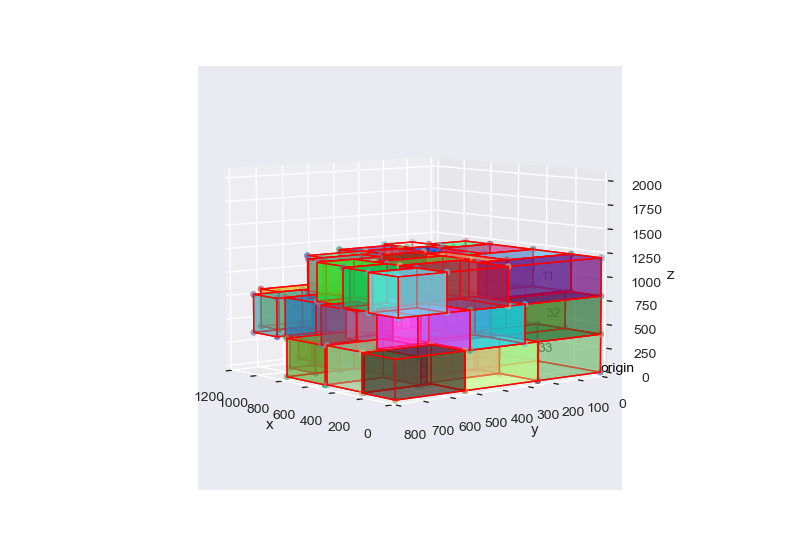

<IPython.core.display.Javascript object>

In [44]:
cg_layer_pool, cg_bins_lbs = main.column_generation_procedure(order, use_cg=True, tlim=None)
cg_layer_pool.to_dataframe()

In [ ]:
cg_bin_pool = bins.BinPool(cg_layer_pool, config.PALLET_DIMS)
cg_bin_pool.plot()

In [ ]:
np.floor(np.mean(cg_bins_lbs) / config.PALLET_HEIGHT)

## Comparison

In [46]:
W, D, _ = config.PALLET_DIMS
print(cg_bin_pool.get_heights())
print(mr_bin_pool.get_heights())
print(cg_layer_pool.get_densities(W, D, two_dims=False))
print(mr_layer_pool.get_densities(W, D, two_dims=False))

[1200]
[1200]
[0.8895229166666667, 0.7886697916666666, 0.71184375]
[0.93044375, 0.9062677083333334, 0.553325]


<IPython.core.display.Javascript object>

## Todo 

### Problemi in Input al modello:
- [ ] Correggere gestione superitem in Heigth groups
    - Problema riguardo stesso Item nello stesso Layer dovuto a superitem Horizontal nei 2 assi -> (Messo in pausa, per ora risolto usando solo Vertical e Single superitems)
    - Suddividere gruppi in piu gruppi 
        - Solo fra superitem con > 1 item e superitem con = 1 item
- [x] Eliminare gruppi con 1 solo item e gruppi con densita minore di 0.5
- [x] Creare Vertical Superitems consistenti alla loro dimensione principale (Da rivedere in caso di aggiunta rotazione, come tutto...)
- [x] Corretto calcolo volume Superitems e aggiunto enclosing_volume per Vertical Superitems
- [ ] Rivedere lower bound martello (L1 viene 0) (L0 corretto) (L2 troppo lento)

### Problemi interni al modello:
- [x] Aggiunto reward in pricing_no_placement per incetivare la costruzione di layer più densi -> Con più item, quindi anche di item con Dual[i]==0, formula di reward con upper_bound = min(dual[i] !=0)
- [x] Modificato pricing placement (v2) per piazzare tutti gli item selezionati se possibile -> Molto lento con 13 item muore ma corretto rispetto a v1 che tendeva per costruzione a non piazzare tutta la sottoparte selezionata
- [x] Aggiunto maxrect placement per i nuovi layer del column generation

    
### Problemi in Output al modello:
- [ ] Aggiungere gestione Weigth a quella della Densità con qualche priorità e spiegazione annessa
- [x] Aggiungere gestione coordinate corretta per i Vertical Superitems, centrare gli oggetti nello spazio occupato
- [x] Controllare select_layer e aggiungere flag per utilizzare solo subset di sottoprocess per testing
- [ ] Sostituire item rimossi in fase di select_layers con altri item non piazzati, usando maxrects
    - [x] per ora: rearrange con maxrects e re-iterazione di tutto il processo con gli item non piazzati
- [x] Gestione Item rimanenti
    1. Piazzare gli ultimi item con algoritmo s-shape
    2. Provare a suddividere lo spazio rimanente in alto anche di layer incompleti in "Sotto pallet" ed usare maxrect su quelli (Magari funziona meglio)
- [ ] Gestione spaziatura 
    - Spaziatura intra-layer spiegata nel paper?
        1. 2 modelli di linear programming -> Spaziatura mediante modelli per width and depth dimensions
        2. Soluzione di spostamento monodirezionale iterativa dei blocchi di un layer (Da pensare per bene come alternativa a 1)
    - Spaziatura inter-layer in altezza
         1. Controllare spazi vuoti anche in altezza al termine di tutto usando una delle 2 tecnice sopradescritte
         
### Aggiunte eventuali
- [ ] Gestione rotazione
- [ ] Oggetti fragili -> Peso + attributi particolari


## TODO tomorrow
- Finire s-shaped
    - Rivedere caso piu di un layer in nuovo bin
- Convertire oggetti in immutabili
    - "If layer in self.layers" lento -> fare come in superitems?
- Solver e search strategy per column generation
    - Da provare: convertire SP PLACEMENT in constraint programming (come fatto con SP NO PLACEMENT)
    - Da provare: rimuovere SP quando si usa maxrects -> ordinare items in base ai duali e chiamare maxrects (packing effettuato su cosa ci entra nel layer)
- Spaziatura
- Dobbiamo passare a SP solo gli item con dual > 0?
- Dobbiamo evitare di processare layer con alpha != 1 (anche in SP no placement)?
- RMP lavora su tutti i layer, solo su quelli nuovi o su una parte?